# <font color='red'>**Automated Model For Inspecting And Evaluating  Answer Scripts**</font>

# <font color='red'>Important Documents</font>

**Base Paper- 01:**https://www.sciencedirect.com/science/article/pii/S1110016824009530

$Mohelr$ $dataset$ $edited$: https://www.kaggle.com/datasets/abdokamr/mohler

$Paper$ $with$ $Mohelr$ $dataset$ $used$: https://aclanthology.org/P11-1076.pdf

$nkazi$ / $SciEntsBank$: https://huggingface.co/datasets/nkazi/SciEntsBank

$Paper$ $with$ $SciENTsBank$ $dataset$ $used$: https://publications.polymtl.ca/5608/1/2021_HadiAbdiGhavidel.pdf

## Import Libraries

In [ ]:
import warnings
import os
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F

from transformers import BertTokenizer, BertModel, T5Tokenizer, T5ForConditionalGeneration

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
)
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier,
    GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, IsolationForest
)
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier, Perceptron, SGDClassifier, PassiveAggressiveClassifier
)
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE


In [ ]:
# @title
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 95.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


#### Dataset Path

In [ ]:
path = kagglehub.dataset_download("abdokamr/mohler")
print("Path to dataset files:", path)

100%|██████████| 82.7k/82.7k [00:00<00:00, 46.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/abdokamr/mohler/versions/1


In [ ]:
print("Files in dataset directory:")
print(os.listdir(path))

Files in dataset directory:
['mohler_dataset_edited.csv']


#### Import Dataset

In [ ]:
csv_file = os.path.join(path, 'mohler_dataset_edited.csv')
mohler_dataset = pd.read_csv(csv_file)

#### Dataframe Columns

In [ ]:
mohler_dataset.columns

Index(['id', 'question', 'desired_answer', 'student_answer', 'score_me',
       'score_other', 'score_avg'],
      dtype='object')

#### Dataframe Shape

In [ ]:
mohler_dataset.shape

(2273, 7)

In [ ]:
mohler_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2273 entries, 0 to 2272
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2273 non-null   float64
 1   question        2273 non-null   object 
 2   desired_answer  2273 non-null   object 
 3   student_answer  2273 non-null   object 
 4   score_me        2273 non-null   float64
 5   score_other     2273 non-null   float64
 6   score_avg       2273 non-null   float64
dtypes: float64(4), object(3)
memory usage: 124.4+ KB


In [ ]:
mohler_dataset

,id,question,desired_answer,student_answer,score_me,score_other,score_avg
0,1.10,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,4.0,3.00,3.500
1,1.10,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,5.00,5.000
2,1.10,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,5.0,3.00,4.000
3,1.10,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,5.00,5.000
4,1.10,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,3.00,3.000
...,...,...,...,...,...,...,...
2268,12.11,How many steps does it take to search a node i...,The height of the tree.,log n,4.5,5.00,4.750
2269,12.11,How many steps does it take to search a node i...,The height of the tree.,( n(n-1) ) / 2,0.0,3.00,1.500
2270,12.11,How many steps does it take to search a node i...,The height of the tree.,2n-1,0.0,4.75,2.375
2271,12.11,How many steps does it take to search a node i...,The height of the tree.,"it takes at most h steps, where h is the heigh...",5.0,5.00,5.000


In [ ]:
null_values = mohler_dataset.isnull().sum()
print("Null values in each column:")
print(null_values)

Null values in each column:
id                0
question          0
desired_answer    0
student_answer    0
score_me          0
score_other       0
score_avg         0
dtype: int64


### Unique Questions with Count

In [ ]:
mohler_dataset['question'].unique()

array(['What is the role of a prototype program in problem solving?',
       'What stages in the software life cycle are influenced by the testing stage?',
       'What are the main advantages associated with object-oriented programming?',
       'Where do C++ programs begin to execute?', 'What is a variable?',
       'Where are variables declared in a C++ program?',
       'What is the main difference between a while and a do...while statement?',
       'What is typically included in a class definition?',
       'What is the difference between a data member and a local variable inside a member function?',
       'What is the difference between a constructor and a function?',
       'When does C++ create a default constructor?',
       'How many constructors can be created for a class?',
       'What is the difference between a function prototype and a function definition?',
       'What is the role of a header-file?',
       'What does a function signature include?',
       'What is t

In [ ]:
unique_questions = mohler_dataset['question'].nunique()
print("Number of unique questions:", unique_questions)

Number of unique questions: 79


#### Unique Ids

In [ ]:
mohler_dataset['id'].unique()

array([ 1.1 ,  1.2 ,  1.3 ,  1.4 ,  1.5 ,  1.6 ,  1.7 ,  2.1 ,  2.2 ,
        2.3 ,  2.4 ,  2.5 ,  2.6 ,  2.7 ,  3.1 ,  3.2 ,  3.3 ,  3.4 ,
        3.5 ,  3.6 ,  3.7 ,  4.1 ,  4.2 ,  4.3 ,  4.4 ,  4.5 ,  5.1 ,
        5.2 ,  5.3 ,  5.4 ,  6.1 ,  6.2 ,  6.3 ,  6.4 ,  6.5 ,  6.6 ,
        6.7 ,  7.1 ,  7.2 ,  7.3 ,  7.4 ,  7.5 ,  7.6 ,  7.7 ,  8.1 ,
        8.2 ,  8.3 ,  8.4 ,  8.6 ,  8.7 ,  9.1 ,  9.2 ,  9.3 ,  9.4 ,
        9.6 , 10.1 , 10.2 , 10.3 , 10.4 , 10.5 , 10.6 , 10.7 , 11.1 ,
       11.2 , 11.3 , 11.4 , 11.5 , 11.6 , 11.7 , 11.8 , 11.9 , 11.11,
       12.1 , 12.2 , 12.4 , 12.5 , 12.6 , 12.7 , 12.8 , 12.9 , 12.11])

In [ ]:
print("Number of unique IDs:", len(mohler_dataset['id'].unique()))

Number of unique IDs: 81


In [ ]:
id_counts = mohler_dataset['id'].value_counts()
id_counts

,count
id,
3.3,31
3.2,31
3.1,31
3.5,31
3.4,31
...,...
10.4,24
10.3,24
10.2,24


<ipython-input-16-c3118f6aa6d4>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=id_counts.index, y=id_counts.values, palette='viridis')


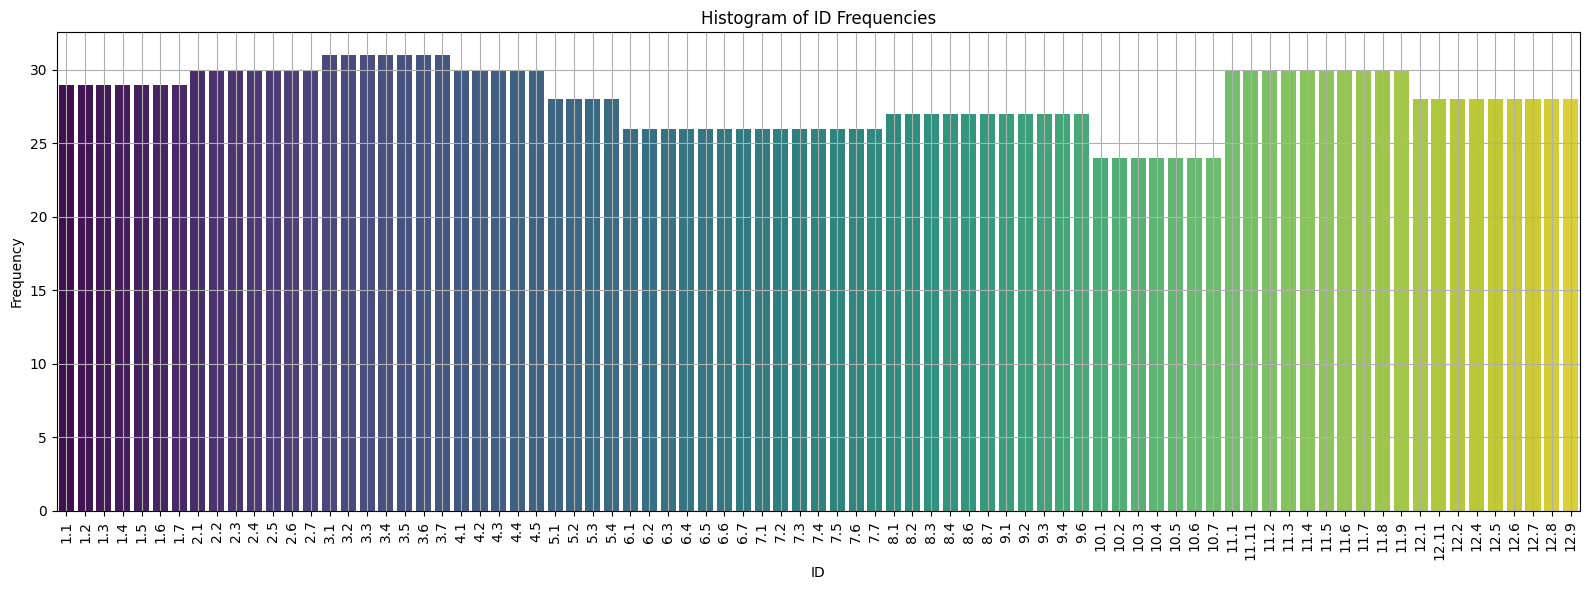

In [ ]:
plt.figure(figsize=(16, 6))
sns.barplot(x=id_counts.index, y=id_counts.values, palette='viridis')
plt.xlabel('ID')
plt.ylabel('Frequency')
plt.title('Histogram of ID Frequencies')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

### Unique Desired Answers

In [ ]:
print("Number of Desired Answers:", len(mohler_dataset['desired_answer'].unique()))

Number of Desired Answers: 80


### Unique Student Answers

In [ ]:
print("Number of Student Answers:", len(mohler_dataset['student_answer'].unique()))

Number of Student Answers: 2172


In [ ]:
2273 - 2172

101

**ScienctsBank**

In [ ]:
splits = {'train': 'data/train-00001.parquet', 'test_ua': 'data/test-ua-00001.parquet', 'test_uq': 'data/test-uq-00001.parquet', 'test_ud': 'data/test-ud-00001.parquet'}
df1 = pd.read_parquet("hf://datasets/nkazi/SciEntsBank/" + splits["train"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df1.columns

Index(['id', 'question', 'reference_answer', 'student_answer', 'label'], dtype='object')

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4969 entries, 0 to 4968
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                4969 non-null   object
 1   question          4969 non-null   object
 2   reference_answer  4969 non-null   object
 3   student_answer    4969 non-null   object
 4   label             4969 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 194.2+ KB


In [ ]:
df1.head()

,id,question,reference_answer,student_answer,label
0,EM.45b.110.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,3
1,EM.45b.113.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,0
2,EM.45b.114.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,0
3,EM.45b.261.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,3
4,EM.45b.383.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,3


In [ ]:
df1['question'].unique().shape

(135,)

In [ ]:
df1.shape

(4969, 5)

In [ ]:
mohler_dataset.head()

,id,question,desired_answer,student_answer,score_me,score_other,score_avg
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,4.0,3.0,3.5
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,5.0,5.0
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,5.0,3.0,4.0
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,5.0,5.0
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,3.0,3.0


In [ ]:
df1.head()

,id,question,reference_answer,student_answer,label
0,EM.45b.110.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,3
1,EM.45b.113.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,0
2,EM.45b.114.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,0
3,EM.45b.261.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,3
4,EM.45b.383.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,3


In [ ]:
df1.rename(columns={'reference_answer': 'desired_answer'}, inplace=True)

In [ ]:
df1

,id,question,desired_answer,student_answer,label
0,EM.45b.110.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,3
1,EM.45b.113.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,0
2,EM.45b.114.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,0
3,EM.45b.261.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,3
4,EM.45b.383.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,3
...,...,...,...,...,...
4964,VB.29.537.1,"When conducting a controlled experiment, why d...",A standard is used for comparison to determine...,To see if the standard might be faster than th...,2
4965,VB.29.542.1,"When conducting a controlled experiment, why d...",A standard is used for comparison to determine...,Because you can compare the results.,2
4966,VB.29.626.1,"When conducting a controlled experiment, why d...",A standard is used for comparison to determine...,To help control the controlled experiment.,3
4967,VB.29.628.1,"When conducting a controlled experiment, why d...",A standard is used for comparison to determine...,To control any experiment.,3


In [ ]:
stacked_df = pd.concat([df1, mohler_dataset], ignore_index=True)

In [ ]:
stacked_df['question'].unique().shape

(214,)

In [ ]:
stacked_df['question'].unique()[:5]

array(['You used several methods to separate and identify the substances in mock rocks. How did you separate the salt from the water?',
       'You used several methods to separate and identify the substances in mock rocks. How did you know the crystals were salt?',
       'Ms. Teridann, a geologist, made a chart showing the scratch-test data for 3 minerals (Mineral X, Mineral Y, and Mineral Z). She wrote "yes" if the tool scratched the mineral and wrote "no" if it did not scratch it. Topaz is a mineral that cannot be scratched by a fingernail, a penny, or a paperclip. How hard is topaz compared to minerals X, Y, and Z? Explain how you know.',
       'Georgia found one brown mineral and one black mineral. How can she test them for hardness using only the 2 minerals (no tools)?',
       'Georgia found one brown mineral and one black mineral. How will she know which one is harder?'],
      dtype=object)

In [ ]:
stacked_df

,id,question,desired_answer,student_answer,label,score_me,score_other,score_avg
0,EM.45b.110.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,3.0,NaN,NaN,NaN
1,EM.45b.113.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,0.0,NaN,NaN,NaN
2,EM.45b.114.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,0.0,NaN,NaN,NaN
3,EM.45b.261.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,3.0,NaN,NaN,NaN
4,EM.45b.383.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
7237,12.11,How many steps does it take to search a node i...,The height of the tree.,log n,NaN,4.5,5.00,4.750
7238,12.11,How many steps does it take to search a node i...,The height of the tree.,( n(n-1) ) / 2,NaN,0.0,3.00,1.500
7239,12.11,How many steps does it take to search a node i...,The height of the tree.,2n-1,NaN,0.0,4.75,2.375
7240,12.11,How many steps does it take to search a node i...,The height of the tree.,"it takes at most h steps, where h is the heigh...",NaN,5.0,5.00,5.000


In [ ]:
splits = {
    'train': 'data/train-00001.parquet',
    'test_ua': 'data/test-ua-00001.parquet',
    'test_uq': 'data/test-uq-00001.parquet',
    'test_ud': 'data/test-ud-00001.parquet'
}

base_path = "hf://datasets/nkazi/SciEntsBank/"

# Load all datasets into a dictionary
dfs = {split: pd.read_parquet(base_path + path) for split, path in splits.items()}

# Access each dataset using dfs['train'], dfs['test_ua'], etc.


In [ ]:
df_combined = pd.concat(dfs.values(), keys=dfs.keys(), names=["split", "index"]).reset_index()

# Display the shape of the combined dataset
print(df_combined.shape)

# Show the first few rows
df_combined.head()


(10804, 7)


,split,index,id,question,reference_answer,student_answer,label
0,train,0,EM.45b.110.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,3
1,train,1,EM.45b.113.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,0
2,train,2,EM.45b.114.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,0
3,train,3,EM.45b.261.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,3
4,train,4,EM.45b.383.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,3


In [ ]:
df_combined.rename(columns={'reference_answer': 'desired_answer'}, inplace=True)

In [ ]:
df_final = pd.concat([df_combined,mohler_dataset], ignore_index = 1)

## Final Dataset

In [ ]:
df_final

,split,index,id,question,desired_answer,student_answer,label,score_me,score_other,score_avg
0,train,0.0,EM.45b.110.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,3.0,NaN,NaN,NaN
1,train,1.0,EM.45b.113.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,0.0,NaN,NaN,NaN
2,train,2.0,EM.45b.114.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,0.0,NaN,NaN,NaN
3,train,3.0,EM.45b.261.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,3.0,NaN,NaN,NaN
4,train,4.0,EM.45b.383.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
13072,NaN,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,log n,NaN,4.5,5.00,4.750
13073,NaN,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,( n(n-1) ) / 2,NaN,0.0,3.00,1.500
13074,NaN,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,2n-1,NaN,0.0,4.75,2.375
13075,NaN,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,"it takes at most h steps, where h is the heigh...",NaN,5.0,5.00,5.000


In [ ]:
df_final = df_final.iloc[:,:-4]

In [ ]:
df_final

,split,index,id,question,desired_answer,student_answer
0,train,0.0,EM.45b.110.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.
1,train,1.0,EM.45b.113.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...
2,train,2.0,EM.45b.114.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.
3,train,3.0,EM.45b.261.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...
4,train,4.0,EM.45b.383.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...
...,...,...,...,...,...,...
13072,NaN,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,log n
13073,NaN,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,( n(n-1) ) / 2
13074,NaN,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,2n-1
13075,NaN,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,"it takes at most h steps, where h is the heigh..."


In [ ]:
df_final['question'].unique().shape

(274,)

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13077 entries, 0 to 13076
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   split           10804 non-null  object 
 1   index           10804 non-null  float64
 2   id              13077 non-null  object 
 3   question        13077 non-null  object 
 4   desired_answer  13077 non-null  object 
 5   student_answer  13077 non-null  object 
dtypes: float64(1), object(5)
memory usage: 613.1+ KB


In [ ]:
df_extract = df_final.iloc[:,[1,2,3,4,5]]
df_extract

,index,id,question,desired_answer,student_answer
0,0.0,EM.45b.110.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.
1,1.0,EM.45b.113.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...
2,2.0,EM.45b.114.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.
3,3.0,EM.45b.261.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...
4,4.0,EM.45b.383.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...
...,...,...,...,...,...
13072,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,log n
13073,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,( n(n-1) ) / 2
13074,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,2n-1
13075,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,"it takes at most h steps, where h is the heigh..."


# Bert Model -01: bert-base-uncased

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

###  Function to get BERT embeddings

In [ ]:
def get_bert_embedding(text):
    if pd.isna(text):  # Handle missing values
        return torch.zeros(768)  # BERT-base has a hidden size of 768
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling over token embeddings
    return embeddings.squeeze()

### Co-sine Similarity

In [ ]:
def cosine_similarity(a, b):
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

In [ ]:
# df_extract['similarity_score'] = df_extract.apply(
#     lambda row: cosine_similarity(), get_bert_embedding(row['student_answer'])),get_bert_embedding(row['desired_answer']
#     axis=1
# )

In [ ]:
df_extract.loc[:99, 'similarity_score'] = df_extract.loc[:99].apply(
    lambda row: cosine_similarity(get_bert_embedding(row['desired_answer']), get_bert_embedding(row['student_answer'])),
    axis=1
)

### OUTPUT

In [ ]:
df_extract.head(100)

,index,id,question,desired_answer,student_answer,similarity_score
0,0.0,EM.45b.110.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,0.585139
1,1.0,EM.45b.113.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,0.802014
2,2.0,EM.45b.114.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,0.897142
3,3.0,EM.45b.261.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,0.746422
4,4.0,EM.45b.383.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,0.656605
...,...,...,...,...,...,...
95,95.0,EM.16b.532.1,"Ms. Teridann, a geologist, made a chart showin...",Topaz would be the hardest of the 4 minerals b...,"It is so strong that minerals X, Y, Z cannot b...",0.690180
96,96.0,EM.16b.538.1,"Ms. Teridann, a geologist, made a chart showin...",Topaz would be the hardest of the 4 minerals b...,I know because when you break a rock that is w...,0.682561
97,97.0,EM.16b.540.1,"Ms. Teridann, a geologist, made a chart showin...",Topaz would be the hardest of the 4 minerals b...,"How it is compared to X, Y, and Z is that the ...",0.725709
98,98.0,EM.16b.573.1,"Ms. Teridann, a geologist, made a chart showin...",Topaz would be the hardest of the 4 minerals b...,I know it is Z because it has one yes and 2 no's.,0.651937


In [ ]:
df_extract.loc[df_extract.index[-100:], 'similarity_score'] = df_extract.iloc[-100:].apply(
    lambda row: cosine_similarity(get_bert_embedding(row['desired_answer']), get_bert_embedding(row['student_answer'])),
    axis=1
)

In [ ]:
df_extract.tail(100)

,index,id,question,desired_answer,student_answer,similarity_score
12977,NaN,12.7,What are the main operations associated with a...,push and pop,push and pop,1.000000
12978,NaN,12.7,What are the main operations associated with a...,push and pop,"Push, Pop, isEmpty, isFull Maybe List to show...",0.452570
12979,NaN,12.7,What are the main operations associated with a...,push and pop,"pop, push",0.832935
12980,NaN,12.7,What are the main operations associated with a...,push and pop,"isempty, push and pop, along with usually,",0.622991
12981,NaN,12.7,What are the main operations associated with a...,push and pop,push and pop,1.000000
...,...,...,...,...,...,...
13072,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,log n,0.441653
13073,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,( n(n-1) ) / 2,0.412287
13074,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,2n-1,0.465542
13075,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,"it takes at most h steps, where h is the heigh...",0.602645


In [ ]:
df_extract[['question', 'desired_answer', 'student_answer', 'similarity_score']].iloc[-10:]

,question,desired_answer,student_answer,similarity_score
13067,How many steps does it take to search a node i...,The height of the tree.,3 steps at most. There are 3 cases.,0.631713
13068,How many steps does it take to search a node i...,The height of the tree.,log(n) where n equals the total number of n...,0.549523
13069,How many steps does it take to search a node i...,The height of the tree.,the same number of steps as the number of leve...,0.672564
13070,How many steps does it take to search a node i...,The height of the tree.,to find a node in a binary search tree takes a...,0.575663
13071,How many steps does it take to search a node i...,The height of the tree.,"three steps visit the root node, then go to ri...",0.529123
13072,How many steps does it take to search a node i...,The height of the tree.,log n,0.441653
13073,How many steps does it take to search a node i...,The height of the tree.,( n(n-1) ) / 2,0.412287
13074,How many steps does it take to search a node i...,The height of the tree.,2n-1,0.465542
13075,How many steps does it take to search a node i...,The height of the tree.,"it takes at most h steps, where h is the heigh...",0.602645
13076,How many steps does it take to search a node i...,The height of the tree.,it depends on the install search tree then fro...,0.549066


## Bert Model -02: t5-small

In [ ]:
model_name = 't5-small'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.eval()


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
# Function to generate text using T5
def generate_text(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    outputs = model.generate(input_ids)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

# Function to get BERT-style embeddings from T5
def get_t5_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model.encoder(**inputs)  # Use the encoder part of T5
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
    return embeddings.squeeze()

# Function to compute cosine similarity
def cosine_similarity(a, b):
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()


In [ ]:
df_extract.loc[:99, 't5_similarity'] = df_extract.iloc[:99].apply(
    lambda row: cosine_similarity(
        get_t5_embedding(generate_text(f"Answer: {row['desired_answer']}")),  # T5-generated text embedding
        get_t5_embedding(row['student_answer'])  # Student answer embedding
    ),
    axis=1
)

### OUTPUT

In [ ]:
df_extract.head(20)

,index,id,question,desired_answer,student_answer,similarity_score,t5_similarity
0,0.0,EM.45b.110.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,0.585139,0.589877
1,1.0,EM.45b.113.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,0.802014,0.825805
2,2.0,EM.45b.114.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,0.897142,0.830115
3,3.0,EM.45b.261.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,0.746422,0.665428
4,4.0,EM.45b.383.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,0.656605,0.716523
5,5.0,EM.45b.384.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.","By pouring the water and salt into the thing, ...",0.739862,0.771323
6,6.0,EM.45b.385.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By slowly pouring it in a tray.,0.570671,0.611216
7,7.0,EM.45b.395.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated so there was only salt left.,0.915266,0.849117
8,8.0,EM.45b.402.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",We put the water with the salt in it and put i...,0.752605,0.739598
9,9.0,EM.45b.416.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I separated the salt from the water because th...,0.693460,0.696469


In [ ]:
%%timeit
df_extract.loc[-100:, 't5_similarity'] = df_extract.iloc[-100:].apply(
    lambda row: cosine_similarity(
        get_t5_embedding(generate_text(f"Answer: {row['desired_answer']}")),  # T5-generated text embedding
        get_t5_embedding(row['student_answer'])  # Student answer embedding
    ),
    axis=1
)

41.6 s ± 1.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
df_extract.tail(20)

15.5 µs ± 2.09 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Bert Model -03 : bert-large-uncased

In [ ]:
model_name = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, 

In [ ]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
    return embeddings.squeeze()

# Function to compute cosine similarity
def cosine_similarity(a, b):
    a, b = a.unsqueeze(0), b.unsqueeze(0)  # Ensure tensors are 2D
    return F.cosine_similarity(a, b).item()

# Compute similarity scores for the last 100 rows
df_extract.loc[df_extract.index[-100:], 'bert-large-uncased_similarity_score'] = df_extract.iloc[-100:].apply(
    lambda row: cosine_similarity(
        get_bert_embedding(row['desired_answer']),
        get_bert_embedding(row['student_answer'])
    ),
    axis=1
)

### OUTPUT

In [ ]:
df_extract.tail(20)

,index,id,question,desired_answer,student_answer,similarity_score,t5_similarity,bert-large-uncased_similarity_score
13057,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,The number of steps to search a node is the fu...,0.554628,0.674172,0.691568
13058,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,"It would take n/2 elements, given n.",0.483783,0.527686,0.464766
13059,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,log(n),0.461177,0.491199,0.680801
13060,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,O(log n),0.431551,0.493233,0.684408
13061,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,O( Log (n) ),0.414906,0.491012,0.573315
13062,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,If the binary search tree is constructed effic...,0.560879,0.581161,0.664336
13063,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,"N, n being the number of nodes.",0.609577,0.603110,0.749462
13064,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,"depending on the way that the tree is ordered,...",0.546633,0.621844,0.671892
13065,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,log(n),0.461177,0.491199,0.680801
13066,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,worst case scenario = the number of levels of ...,0.623093,0.653742,0.683625


In [ ]:
df_extract['question'].unique()[-1:]

array(['How many steps does it take to search a node in a binary search tree?'],
      dtype=object)

In [ ]:
df_extract['student_answer'].unique()[-20:]

array(['Given n elements, it would take n/2 steps to find the search criteria.',
       'log n',
       'Depends on the location of the node you are looking for. If it is the root it is one step.  else If it is smaller than the current you are on node you go to the left.  If it is larger than the current node you are on go to the right.',
       '2^n where n is the # of levels the binary tree has',
       'The number of steps to search a node is the function n-1.',
       'It would take n/2 elements, given n.', 'O( Log (n) )',
       'If the binary search tree is constructed efficiently, best case scenario is O(log n) time.  Where n is the number of items in the tree.  If the binary search tree is constructed poorly, with for instance the root of the tree being 1, and progressing downwards and to the right its children are each more than the last: you have a one-way linear linked list.  That worse case scenario would be a full traversal at O(n) time. Where n is the number of items in t

In [ ]:
df_extract.describe()

,index,similarity_score,t5_similarity,bert-large-uncased_similarity_score
count,10804.000000,200.000000,100.000000,100.000000
mean,2143.691688,0.703573,0.661014,0.779018
std,1460.900427,0.146187,0.113295,0.137348
min,0.000000,0.249792,0.360111,0.464766
25%,720.000000,0.598865,0.576337,0.670003
50%,2064.000000,0.714382,0.683696,0.819098
75%,3414.250000,0.810630,0.749740,0.893114
max,4968.000000,1.000000,0.851224,1.000000


In [ ]:
df_extract.query('similarity_score > 0.5')

,index,id,question,desired_answer,student_answer,similarity_score,t5_similarity,bert-large-uncased_similarity_score
0,0.0,EM.45b.110.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,0.585139,NaN,NaN
1,1.0,EM.45b.113.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,0.802014,NaN,NaN
2,2.0,EM.45b.114.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,0.897142,NaN,NaN
3,3.0,EM.45b.261.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,0.746422,NaN,NaN
4,4.0,EM.45b.383.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,0.656605,NaN,NaN
...,...,...,...,...,...,...,...,...
13069,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,the same number of steps as the number of leve...,0.672564,0.647854,0.716462
13070,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,to find a node in a binary search tree takes a...,0.575663,0.610196,0.672657
13071,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,"three steps visit the root node, then go to ri...",0.529123,0.487099,0.600857
13075,NaN,12.11,How many steps does it take to search a node i...,The height of the tree.,"it takes at most h steps, where h is the heigh...",0.602645,0.690547,0.709279


### Only Text dataset

In [ ]:
only_text_df = df_extract.iloc[:,[1,2,3,4]]

In [ ]:
only_text_df

,id,question,desired_answer,student_answer
0,EM.45b.110.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.
1,EM.45b.113.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...
2,EM.45b.114.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.
3,EM.45b.261.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...
4,EM.45b.383.1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...
...,...,...,...,...
13072,12.11,How many steps does it take to search a node i...,The height of the tree.,log n
13073,12.11,How many steps does it take to search a node i...,The height of the tree.,( n(n-1) ) / 2
13074,12.11,How many steps does it take to search a node i...,The height of the tree.,2n-1
13075,12.11,How many steps does it take to search a node i...,The height of the tree.,"it takes at most h steps, where h is the heigh..."


In [ ]:
df_extract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13077 entries, 0 to 13076
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   index                                10804 non-null  float64
 1   id                                   13077 non-null  object 
 2   question                             13077 non-null  object 
 3   desired_answer                       13077 non-null  object 
 4   student_answer                       13077 non-null  object 
 5   similarity_score                     200 non-null    float64
 6   t5_similarity                        100 non-null    float64
 7   bert-large-uncased_similarity_score  100 non-null    float64
dtypes: float64(4), object(4)
memory usage: 817.4+ KB


In [ ]:
custom_path = r"C:\Users\Asus\OneDrive\Desktop\Prj-3\text-only.xlsx"

# # Save DataFrame to the specified path
# only_text_df.to_excel(custom_path, index=False)

# print(f"Excel file saved successfully at: {custom_path}")


### Preprocessing

In [ ]:
file_path = r"/content/C__Users_Asus_OneDrive_Desktop_Prj-3_text-only.xlsx"  # Update with your correct path
df = pd.read_excel(file_path, sheet_name="Sheet1")

In [ ]:
df_cleaned = df.dropna(subset=['student_answer']).copy()
df_cleaned.shape

(13068, 4)

#### Perform TF-IDF

In [ ]:
X = df_cleaned['student_answer']  # Student responses (text)
y = df_cleaned['desired_answer']  # Desired correct responses (text)

# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for efficiency
X_tfidf = vectorizer.fit_transform(X)

In [ ]:
vectorizer

TfidfVectorizer(max_features=5000)

### Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42,shuffle = True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10454, 4641), (2614, 4641), (10454,), (2614,))

### K-Fold

In [ ]:
print("\nPerforming K-Fold Cross-Validation...\n")

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(LogisticRegression(max_iter=1000), X_tfidf, y, cv=kf, scoring='accuracy', n_jobs=-1)

cv_scores = cross_val_score(LogisticRegression(max_iter=1000), X_tfidf, y, cv=kf, scoring='accuracy')
print(f"K-Fold Accuracy Scores: {cv_scores}")
print(f"Mean K-Fold Accuracy: {cv_scores.mean():.4f}")


Performing K-Fold Cross-Validation...

K-Fold Accuracy Scores: [0.69395562 0.7096404  0.71002295 0.69843092 0.69613471]
Mean K-Fold Accuracy: 0.7016


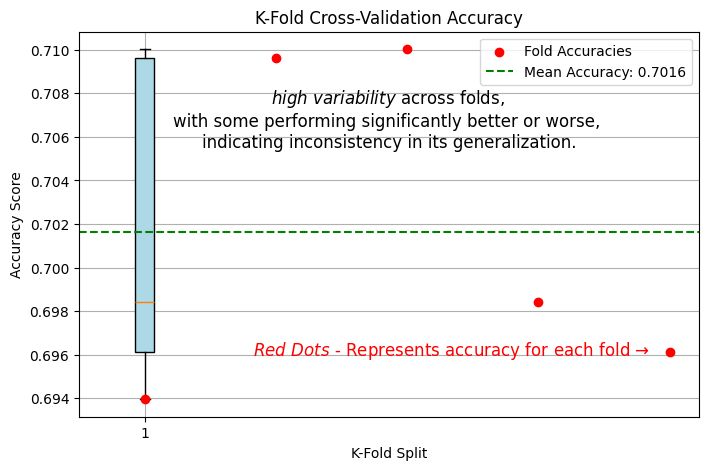

In [ ]:
plt.figure(figsize=(8, 5))

# Box Plot of Accuracy Scores
plt.boxplot(cv_scores, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.scatter(range(1, len(cv_scores) + 1), cv_scores, color='red', label="Fold Accuracies", zorder=3)
plt.axhline(y=cv_scores.mean(), color='green', linestyle='--', label=f"Mean Accuracy: {cv_scores.mean():.4f}")

# Labels and Titles
plt.xlabel("K-Fold Split")
plt.ylabel("Accuracy Score")
plt.title("K-Fold Cross-Validation Accuracy")
plt.text(0.5, 0.70, f"$high$ $variability$ across folds, \nwith some performing significantly better or worse, \nindicating inconsistency in its generalization.", transform=plt.gca().transAxes, ha='center',size = 12)
plt.text(0.6, 0.16, f"$Red$ $Dots$ - Represents accuracy for each fold →", transform=plt.gca().transAxes, ha='center',size = 12,color='red')
plt.legend()
plt.grid(True)

# Show Plot
plt.show()

### Base Models

In [ ]:
!pip install catboost

#Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)  # Increased max_iter to ensure convergence

# Train the model
log_reg.fit(X_train, y_train)

# Predict on test data
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy Score: 0.9927314460596787

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2595
           1       0.00      0.00      0.00        19

    accuracy                           0.99      2614
   macro avg       0.50      0.50      0.50      2614
weighted avg       0.99      0.99      0.99      2614



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
df_cleaned['label'] = (df_cleaned['student_answer'].str.strip().str.lower() == df_cleaned['desired_answer'].str.strip().str.lower()).astype(int)


In [ ]:
X = df_cleaned['student_answer']
y = df_cleaned['label']

vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy Score: 0.9927314460596787

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2595
           1       0.00      0.00      0.00        19

    accuracy                           0.99      2614
   macro avg       0.50      0.50      0.50      2614
weighted avg       0.99      0.99      0.99      2614



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# Predict probabilities for the positive class
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Compute regression-style metrics
print("R² Score (on predicted probabilities):", r2_score(y_test, y_pred_proba))
print("MSE (on predicted probabilities):", mean_squared_error(y_test, y_pred_proba))


R² Score (on predicted probabilities): 0.3406607998771416
MSE (on predicted probabilities): 0.004757608413945734


In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration_curve(y_true, y_proba, model_name="Model"):
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=10, strategy='uniform')

    plt.figure(figsize=(7, 5))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
    plt.title(f"{model_name} - Calibration Curve")
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_probability_histogram(y_proba, model_name="Model"):
    plt.figure(figsize=(7, 4))
    plt.hist(y_proba, bins=20, edgecolor='k', alpha=0.7)
    plt.title(f"{model_name} - Histogram of Predicted Probabilities")
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


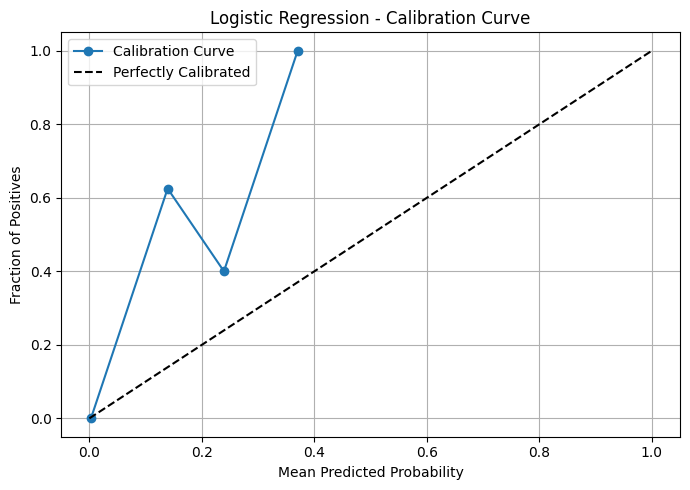

In [ ]:
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, y_pred_proba, model_name="Logistic Regression")


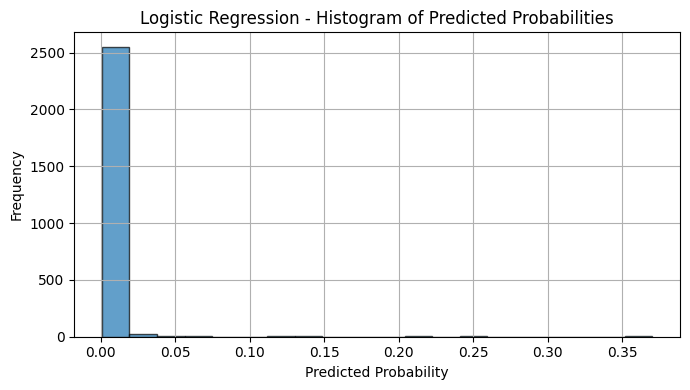

In [ ]:
plot_probability_histogram(y_pred_proba, model_name="Logistic Regression")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_actual_vs_predicted(y_true, y_pred, model_name="Regression Model"):
    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolor='k')
    plt.plot([0, 1], [0, 1], '--', color='red', label='Perfect Prediction')
    plt.title(f"{model_name} - Actual vs Predicted Similarity")
    plt.xlabel("Actual Similarity")
    plt.ylabel("Predicted Similarity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_actual_vs_predicted_probabilities(y_true, y_proba, model_name="Logistic Regression"):
    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, y_proba, alpha=0.6, edgecolor='k')
    plt.title(f"{model_name} - Actual Labels vs Predicted Probabilities")
    plt.xlabel("Actual Label (0 or 1)")
    plt.ylabel("Predicted Probability")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


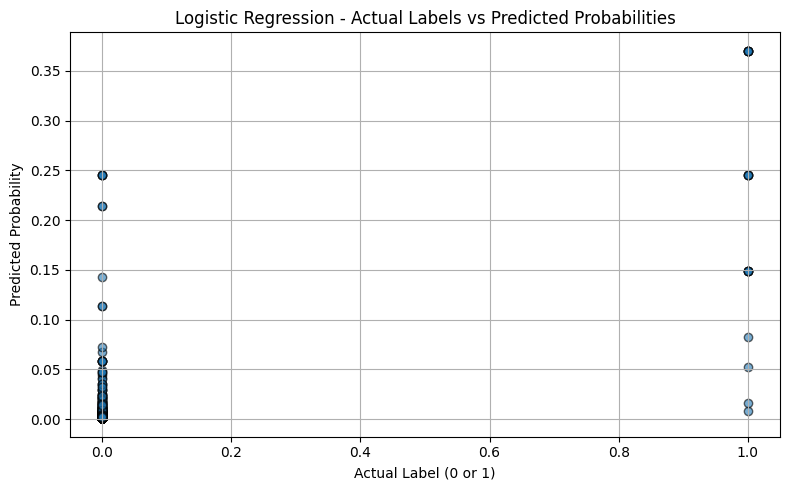

In [ ]:
from sklearn.linear_model import LogisticRegression

# After fitting your logistic regression model
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

plot_actual_vs_predicted_probabilities(y_test, y_pred_proba, model_name="Logistic Regression")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_actual_vs_predicted_probabilities_with_regression(y_true, y_proba, model_name="Logistic Regression"):
    plt.figure(figsize=(8, 5))
    sns.regplot(x=y_proba, y=y_true, logistic=True, ci=None, scatter_kws={'alpha': 0.6, 'edgecolor': 'k'})
    plt.title(f"{model_name} - Predicted Probabilities vs Actual Labels")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Actual Label (0 or 1)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


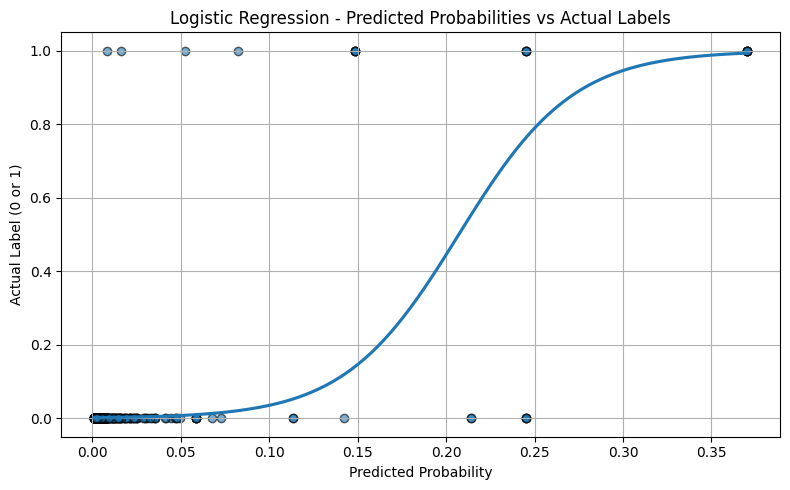

In [ ]:
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
plot_actual_vs_predicted_probabilities_with_regression(y_test, y_pred_proba, model_name="Logistic Regression")


# OLS Regression

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Vectorize both student and desired answers
student_tfidf = vectorizer.transform(df_cleaned['student_answer'])
desired_tfidf = vectorizer.transform(df_cleaned['desired_answer'])

# Compute cosine similarity row-wise
similarities = np.array([
    cosine_similarity(student_tfidf[i], desired_tfidf[i])[0][0]
    for i in range(student_tfidf.shape[0])
])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Use student answer TF-IDF features
X = student_tfidf
y = similarities  # similarity scores (float between 0 and 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply OLS regression
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

# Predict
y_pred = ols_model.predict(X_test)

# Evaluation
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


R² Score: 0.6046272336194487
MSE: 0.022995879902847568


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load the dataset
file_path = r"/content/C__Users_Asus_OneDrive_Desktop_Prj-3_text-only.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")
df_cleaned = df.dropna(subset=['student_answer']).copy()

# Step 2: Prepare text data
X_text = df_cleaned['student_answer']
y_text = df_cleaned['desired_answer']

# Step 3: TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X_text)
y_tfidf = vectorizer.transform(y_text)

# Step 4: Compute cosine similarity between each student-desired answer pair
similarities = np.array([
    cosine_similarity(X_tfidf[i], y_tfidf[i])[0][0]
    for i in range(X_tfidf.shape[0])
])

# Step 5: Train-test split using student answer TF-IDF as input, similarity as target
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, similarities, test_size=0.2, random_state=42, shuffle=True
)

# Step 6: Train OLS regression model
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

# Step 7: Predict similarity scores
y_pred = ols_model.predict(X_test)

# Step 8: Evaluate
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))



R² Score: 0.18563983848991739
MSE: 0.04219753706962398


In [ ]:
# Convert similarity scores to binary: similar (>=0.5) vs not similar (<0.5)
y_test_class = (y_test >= 0.5).astype(int)
y_pred_class = (y_pred >= 0.5).astype(int)

from sklearn.metrics import accuracy_score
print("Accuracy (Threshold = 0.5):", accuracy_score(y_test_class, y_pred_class))


Accuracy (Threshold = 0.5): 0.8932670237184391


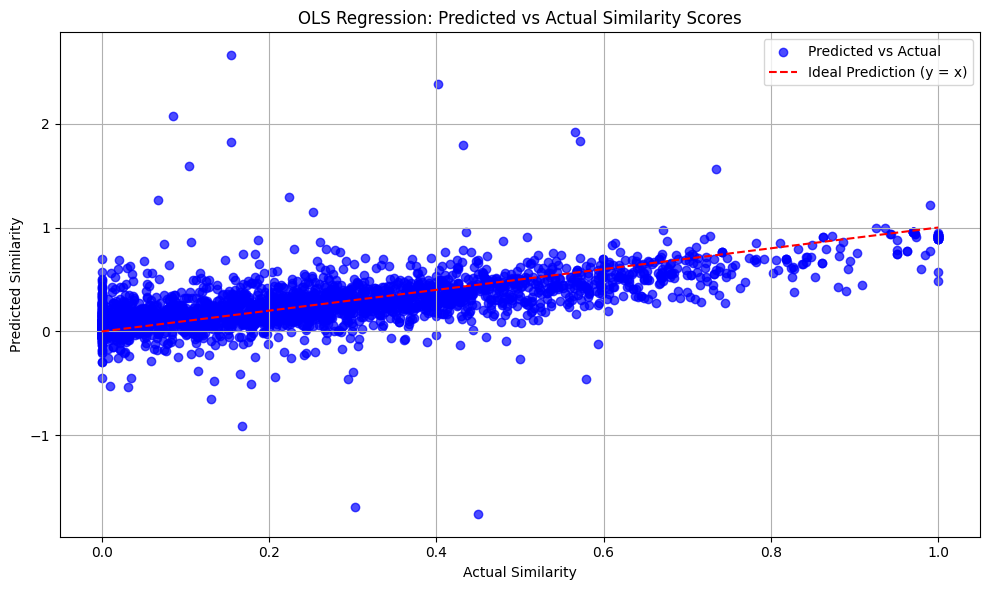

In [ ]:
# Step 9: Plot actual vs predicted similarity
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], 'r--', label='Ideal Prediction (y = x)')
plt.xlabel('Actual Similarity')
plt.ylabel('Predicted Similarity')
plt.title('OLS Regression: Predicted vs Actual Similarity Scores')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# SVR

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Use your cleaned data
X_text = df_cleaned['student_answer']
y_text = df_cleaned['desired_answer']

# Vectorize with limited features for performance
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(X_text)
y_tfidf = vectorizer.transform(y_text)

# Compute cosine similarity as target
similarities = np.array([
    cosine_similarity(X_tfidf[i], y_tfidf[i])[0][0]
    for i in range(X_tfidf.shape[0])
])

# Convert sparse matrix to dense
X_dense = X_tfidf.toarray()

# Optional: Subsample to speed up SVR
sample_limit = 3000
X_dense = X_dense[:sample_limit]
similarities = similarities[:sample_limit]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_dense, similarities, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVR with RBF kernel
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
svr_model.fit(X_train_scaled, y_train)

# Predict
y_pred = svr_model.predict(X_test_scaled)

# Evaluation
print("SVR (RBF) R² Score:", r2_score(y_test, y_pred))
print("SVR (RBF) MSE:", mean_squared_error(y_test, y_pred))



SVR (RBF) R² Score: 0.5843106847208642
SVR (RBF) MSE: 0.021191882346386953


In [ ]:
from sklearn.metrics import accuracy_score

# Convert true and predicted similarities to binary classes
y_test_class = (y_test >= 0.5).astype(int)
y_pred_class = (y_pred >= 0.5).astype(int)

# Compute accuracy
accuracy = accuracy_score(y_test_class, y_pred_class)
print("Binary Accuracy (Threshold 0.5):", accuracy)


Binary Accuracy (Threshold 0.5): 0.875


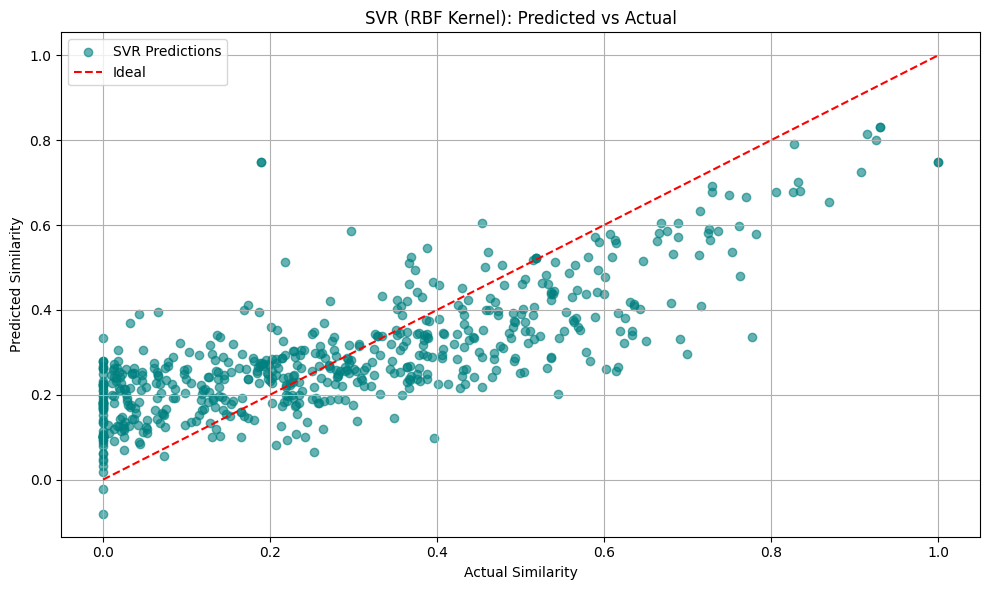

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal', label='SVR Predictions')
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlabel('Actual Similarity')
plt.ylabel('Predicted Similarity')
plt.title('SVR (RBF Kernel): Predicted vs Actual')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert actual and predicted similarities into binary classes
threshold = 0.75
y_test_class = (y_test >= threshold).astype(int)
y_pred_class = (y_pred >= threshold).astype(int)

# Classification report
print("\nClassification Report (Threshold = 0.75):")
print(classification_report(y_test_class, y_pred_class, target_names=["Incorrect", "Correct"]))

# Confusion matrix
cm = confusion_matrix(y_test_class, y_pred_class)
print("Confusion Matrix:\n", cm)




Classification Report (Threshold = 0.75):
              precision    recall  f1-score   support

   Incorrect       0.98      1.00      0.99       581
     Correct       1.00      0.26      0.42        19

    accuracy                           0.98       600
   macro avg       0.99      0.63      0.70       600
weighted avg       0.98      0.98      0.97       600

Confusion Matrix:
 [[581   0]
 [ 14   5]]


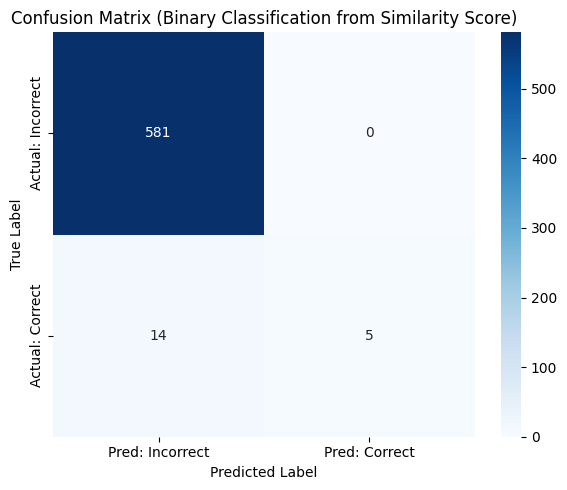

In [ ]:
# Optional: Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred: Incorrect", "Pred: Correct"],
            yticklabels=["Actual: Incorrect", "Actual: Correct"])
plt.title("Confusion Matrix (Binary Classification from Similarity Score)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("Random Forest R² Score:", r2_score(y_test, y_pred_rf))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))


Random Forest R² Score: 0.5809350786854994
Random Forest MSE: 0.02136397107544453


In [ ]:
from sklearn.metrics import accuracy_score

# Convert similarity scores to binary classes (1 = similar, 0 = not similar)
y_test_class = (y_test >= 0.5).astype(int)
y_pred_class_rf = (y_pred_rf >= 0.5).astype(int)

# Accuracy
accuracy_rf = accuracy_score(y_test_class, y_pred_class_rf)
print("Random Forest Binary Accuracy (Threshold 0.5):", accuracy_rf)


Random Forest Binary Accuracy (Threshold 0.5): 0.865


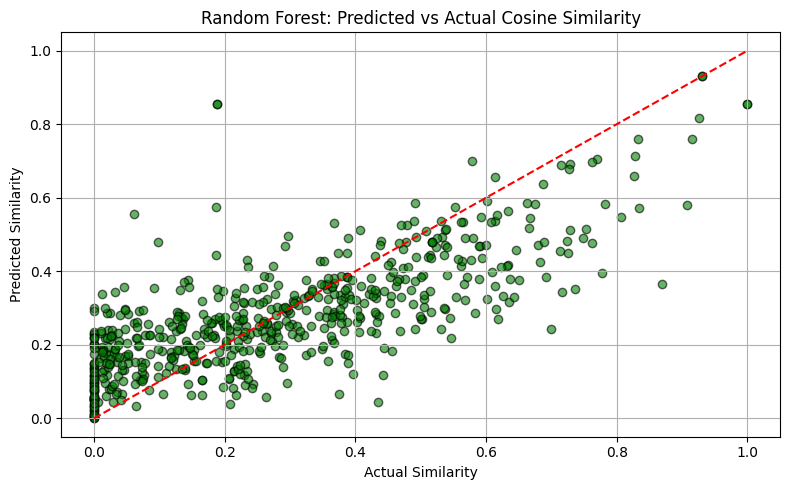

In [ ]:
# --- Plot Actual vs Predicted Similarities ---
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='green', edgecolor='k')
plt.plot([0, 1], [0, 1], '--', color='red')  # Ideal line
plt.title("Random Forest: Predicted vs Actual Cosine Similarity")
plt.xlabel("Actual Similarity")
plt.ylabel("Predicted Similarity")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# --- Classification by threshold ---
threshold = 0.75
y_test_class = (y_test >= threshold).astype(int)
y_pred_class = (y_pred_rf >= threshold).astype(int)

print("\n🔸 Classification Report (Threshold = 0.75):")
print(classification_report(y_test_class, y_pred_class, target_names=["Incorrect", "Correct"]))



🔸 Classification Report (Threshold = 0.75):
              precision    recall  f1-score   support

   Incorrect       0.98      1.00      0.99       581
     Correct       0.78      0.37      0.50        19

    accuracy                           0.98       600
   macro avg       0.88      0.68      0.74       600
weighted avg       0.97      0.98      0.97       600



In [ ]:
## When Threshold = 0.50
from sklearn.metrics import classification_report
print(classification_report(y_test_class, y_pred_class_rf))


              precision    recall  f1-score   support

           0       0.87      0.98      0.92       489
           1       0.80      0.36      0.50       111

    accuracy                           0.86       600
   macro avg       0.84      0.67      0.71       600
weighted avg       0.86      0.86      0.84       600



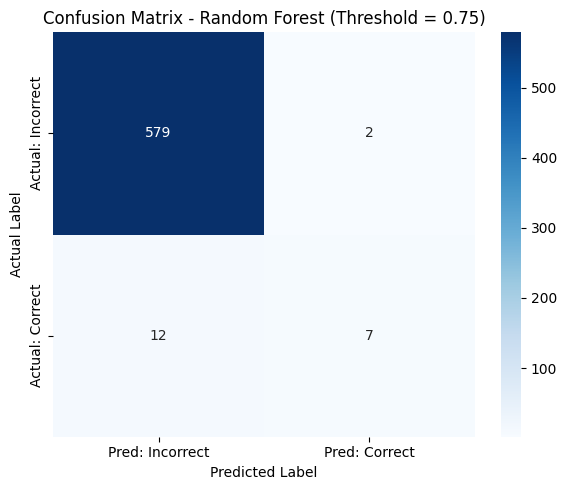

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred: Incorrect", "Pred: Correct"],
            yticklabels=["Actual: Incorrect", "Actual: Correct"])
plt.title("Confusion Matrix - Random Forest (Threshold = 0.75)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

# Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)

print("Gradient Boosting R² Score:", r2_score(y_test, y_pred_gb))
print("Gradient Boosting MSE:", mean_squared_error(y_test, y_pred_gb))


Gradient Boosting R² Score: 0.37133823918060294
Gradient Boosting MSE: 0.03204923865317786


In [ ]:
# --- Classification threshold ---
threshold = 0.75
y_test_class = (y_test >= threshold).astype(int)
y_pred_class = (y_pred_gb >= threshold).astype(int)

# Accuracy & classification report
print("\n🔸 Accuracy:", accuracy_score(y_test_class, y_pred_class))
print("\n🔸 Classification Report (Threshold = 0.75):")
print(classification_report(y_test_class, y_pred_class, target_names=["Incorrect", "Correct"]))




🔸 Accuracy: 0.9716666666666667

🔸 Classification Report (Threshold = 0.75):
              precision    recall  f1-score   support

   Incorrect       0.97      1.00      0.99       581
     Correct       1.00      0.11      0.19        19

    accuracy                           0.97       600
   macro avg       0.99      0.55      0.59       600
weighted avg       0.97      0.97      0.96       600



In [ ]:
threshold = 0.50
y_test_class = (y_test >= threshold).astype(int)
y_pred_class = (y_pred_gb >= threshold).astype(int)

# Accuracy & classification report
print("\n🔸 Accuracy:", accuracy_score(y_test_class, y_pred_class))
print("\n🔸 Classification Report (Threshold = 0.75):")
print(classification_report(y_test_class, y_pred_class, target_names=["Incorrect", "Correct"]))


🔸 Accuracy: 0.845

🔸 Classification Report (Threshold = 0.75):
              precision    recall  f1-score   support

   Incorrect       0.84      1.00      0.91       489
     Correct       0.91      0.18      0.30       111

    accuracy                           0.84       600
   macro avg       0.88      0.59      0.61       600
weighted avg       0.85      0.84      0.80       600



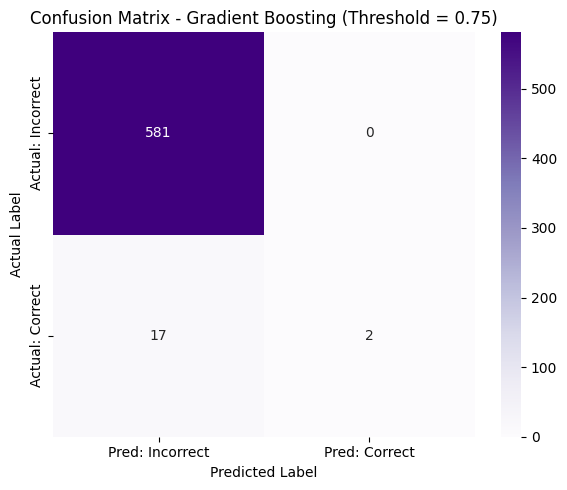

In [ ]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test_class, y_pred_class)


# --- Plot Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=["Pred: Incorrect", "Pred: Correct"],
            yticklabels=["Actual: Incorrect", "Actual: Correct"])
plt.title("Confusion Matrix - Gradient Boosting (Threshold = 0.75)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()



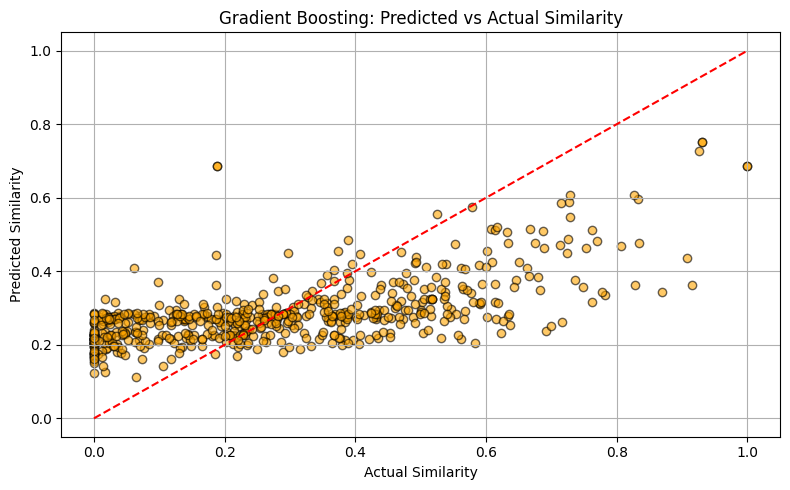

In [ ]:
# --- Plot Predicted vs Actual Similarity Scores ---
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_gb, alpha=0.6, color='orange', edgecolor='k')
plt.plot([0, 1], [0, 1], '--', color='red')  # ideal line
plt.title("Gradient Boosting: Predicted vs Actual Similarity")
plt.xlabel("Actual Similarity")
plt.ylabel("Predicted Similarity")
plt.grid(True)
plt.tight_layout()
plt.show()

# Bagging Regressor & Boosting

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# For older versions of scikit-learn, use 'base_estimator' as a positional argument:
bag_model = BaggingRegressor(
    DecisionTreeRegressor(),  # Positional argument
    n_estimators=100,
    random_state=42
)

bag_model.fit(X_train_scaled, y_train)
y_pred_bag = bag_model.predict(X_test_scaled)

print("🔹 Bagging R² Score:", r2_score(y_test, y_pred_bag))
print("🔹 Bagging MSE:", mean_squared_error(y_test, y_pred_bag))

🔹 Bagging R² Score: 0.5796068239891248
🔹 Bagging MSE: 0.021431685631044087


In [ ]:
from sklearn.ensemble import AdaBoostRegressor

boost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
boost_model.fit(X_train_scaled, y_train)
y_pred_boost = boost_model.predict(X_test_scaled)

print("🔹 AdaBoost R² Score:", r2_score(y_test, y_pred_boost))
print("🔹 AdaBoost MSE:", mean_squared_error(y_test, y_pred_boost))


🔹 AdaBoost R² Score: 0.06980027393895749
🔹 AdaBoost MSE: 0.04742167390107176


In [ ]:
def evaluate_model(y_true, y_pred, model_name="Model", threshold=0.75):
    y_true_class = (y_true >= threshold).astype(int)
    y_pred_class = (y_pred >= threshold).astype(int)

    print(f"\n🔸 {model_name} Accuracy:", accuracy_score(y_true_class, y_pred_class))
    print(f"\n🔸 {model_name} Classification Report:")
    print(classification_report(y_true_class, y_pred_class, target_names=["Incorrect", "Correct"]))

    cm = confusion_matrix(y_true_class, y_pred_class)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Pred: Incorrect", "Pred: Correct"],
                yticklabels=["Actual: Incorrect", "Actual: Correct"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Plot Predicted vs Actual Similarity
    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolor='k')
    plt.plot([0, 1], [0, 1], '--', color='red')
    plt.title(f"{model_name} - Predicted vs Actual")
    plt.xlabel("Actual Similarity")
    plt.ylabel("Predicted Similarity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



🔸 Bagging Regressor Accuracy: 0.9766666666666667

🔸 Bagging Regressor Classification Report:
              precision    recall  f1-score   support

   Incorrect       0.98      1.00      0.99       581
     Correct       0.78      0.37      0.50        19

    accuracy                           0.98       600
   macro avg       0.88      0.68      0.74       600
weighted avg       0.97      0.98      0.97       600



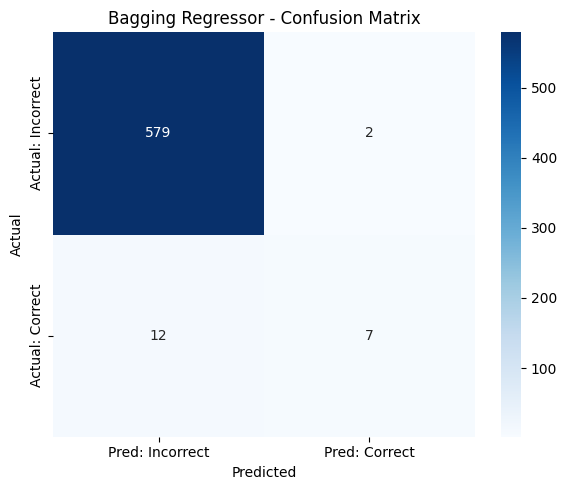

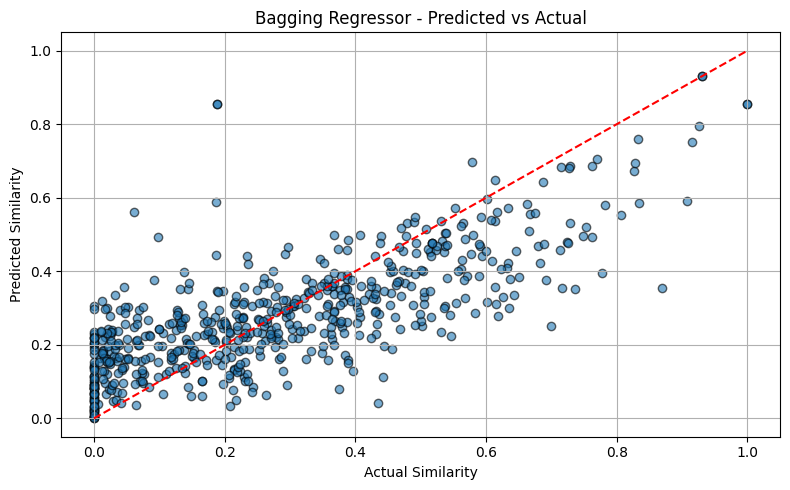

In [ ]:
evaluate_model(y_test, y_pred_bag, model_name="Bagging Regressor")



🔸 AdaBoost Regressor Accuracy: 0.9716666666666667

🔸 AdaBoost Regressor Classification Report:
              precision    recall  f1-score   support

   Incorrect       0.97      1.00      0.99       581
     Correct       0.67      0.21      0.32        19

    accuracy                           0.97       600
   macro avg       0.82      0.60      0.65       600
weighted avg       0.96      0.97      0.96       600



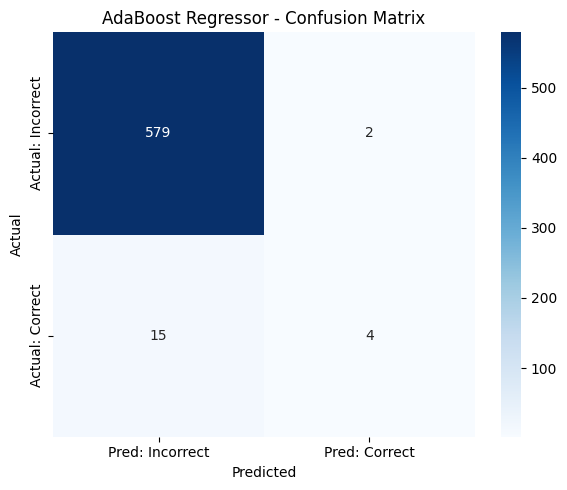

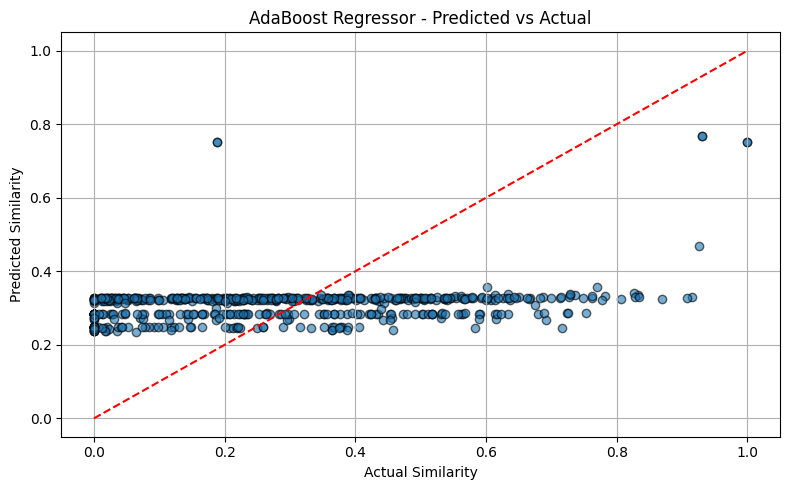

In [ ]:
evaluate_model(y_test, y_pred_boost, model_name="AdaBoost Regressor")


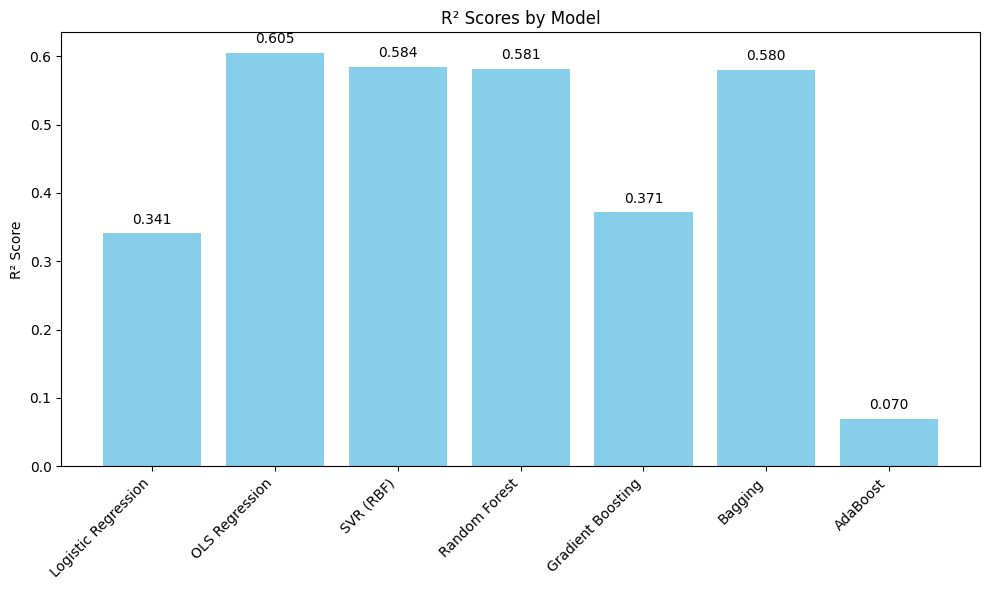

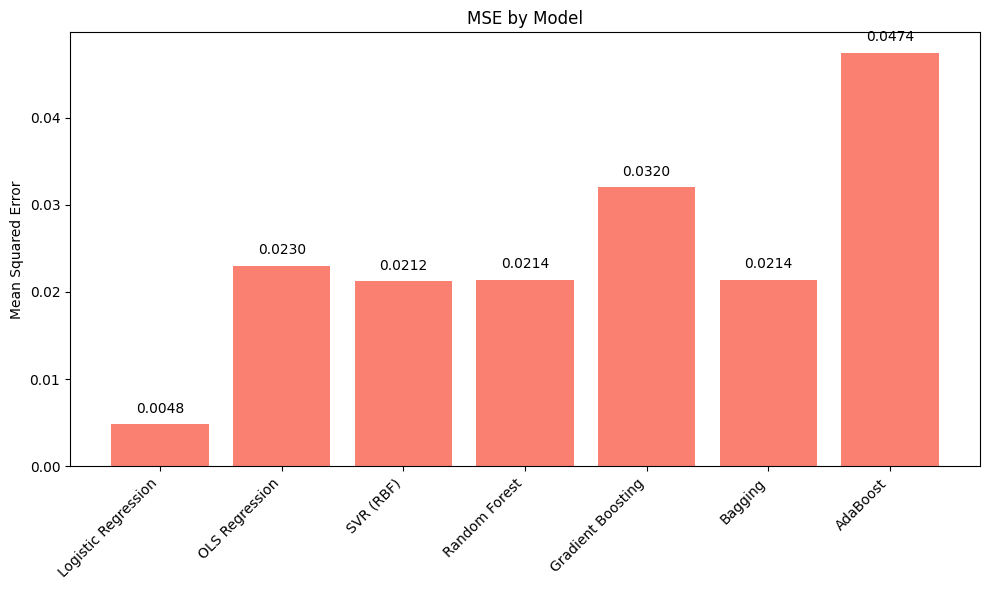

In [ ]:
import matplotlib.pyplot as plt

# Data
models = ['Logistic Regression', 'OLS Regression', 'SVR (RBF)',
          'Random Forest', 'Gradient Boosting', 'Bagging', 'AdaBoost']

r2_scores = [0.3407, 0.6046, 0.5843, 0.5809, 0.3713, 0.5796, 0.0698]
mse_values = [0.0048, 0.0230, 0.0212, 0.0214, 0.0320, 0.0214, 0.0474]

# Plot R² Scores
plt.figure(figsize=(10, 6))
bars = plt.bar(models, r2_scores, color='skyblue')
plt.title('R² Scores by Model')
plt.ylabel('R² Score')
plt.xticks(rotation=45, ha='right')

# Add values on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plot MSE
plt.figure(figsize=(10, 6))
bars = plt.bar(models, mse_values, color='salmon')
plt.title('MSE by Model')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45, ha='right')

# Add values on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),## ensemble
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier()
}

# Step 2: Train base models and display accuracy
print("\nTraining Base ML Models...\n")
model_results = {}

for name, model in base_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_results[name] = accuracy
    print(f"{name} A ccuracy: {accuracy:.4f}")


Training Base ML Models...

Logistic Regression Accuracy: 0.6882
Naive Bayes Accuracy: 0.5218
Random Forest Accuracy: 0.6714
Gradient Boosting Accuracy: 0.4943
SVM Accuracy: 0.6928
KNN Accuracy: 0.4629
Decision Tree Accuracy: 0.5275
Extra Trees Accuracy: 0.6844


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275], got ['10 milliliters to 20 milliliters. The radishes did not grow at all in pots one and 5 so the range of tolerance is for pots 2, 3 and 4, which got 10 to 20 milliliters of water.'
 '20 centimeters size is between 10 and 30 centimeters, so the temperature change must be less than the 30 centimeters container, but more than the 10 centimeters container. 6 degrees Celsius is halfway between.'
 '2: Trace the features from the photograph onto the overlay grid. 4: Transfer the features to the matching squares on the smaller grid in your notebook.'
 '40 meters. The change in elevation is 20 meters between A and B and 20 meters between B and C. So the change between A and C is 40 meters. 20 m plus 20 m equals 40 m.'
 'A bigger hole puts more water in the stream. Increased flow moves more earth materials, increasing erosion. A steeper slope makes the water flow faster. Faster flow moves more earth materials, increasing erosion.'
 'A binary tree that has the property that for any node the left child is smaller than the parent which in turn is smaller than the right child.'
 'A car is made of a lot of iron or steel.'
 'A chemical reaction occurred. [The white solid is a precipitate (a new material) which indicates the reaction.]'
 'A collection of elements that can be allocated dynamically.'
 'A collection of nodes, which has a special node called root, and the rest of the nodes are partitioned into one or more disjoint sets, each set being a tree.'
 'A constructor is called whenever an object is created, whereas a function needs to be called explicitely. Constructors do not have return type, but functions have to indicate a return type.'
 'A data structure that can store elements, which has the property that the last item added will be the first to be removed (or last-in-first-out)'
 'A data structure that can store elements, which has the property that the last item added will be the last to be removed (or first-in-first-out).'
 'A data structure that stores elements following the first in first out principle. The main operations in a queue are enqueue and dequeue.'
 "A function prototype includes the function signature, i.e., the name of the function, the return type, and the parameters' type. The function definition includes the actual body of the function."
 'A function that calls itself.'
 'A heat sink is any material that absorbs (a lot of) heat.'
 'A heat sink would absorb heat during the daytime and release the heat during the nighttime to keep the house warmer longer.'
 'A location in memory that can store a value.'
 'A node that has no children.'
 'A paperclip is harder than a penny, so if a penny can scratch a mineral, a paperclip can also scratch the mineral.'
 'A reaction was indicated by the bubbles of gas (a new material) being produced.'
 'A rock is made up of many substances which are minerals. A mineral is an earth material that is one substance - a mineral can not be broken down further.'
 'A solution is a mixture formed when a solid dissolves in a liquid.'
 'A solution was created when the eggshells disappeared (dissolved) and the mixture ended up as a clear liquid.'
 'A standard is used for comparison to determine how changing one variable changes the results.'
 'A tree for which the maximum number of children per node is two.'
 'A variable that contains the address in memory of another variable.'
 'A walk around the tree, starting with the root, where each node is seen three times: from the left, from below, from the right.'
 'A. Dry soil heats more quickly and cools off more quickly than water. The graph shows A heats and cools more quickly than B, so A must be the dry soil.'
 "A. The water in Julie's heater got hotter faster (or had a greater temperature change in 20 minutes). The collector in heater A has the greater surface area so the water in A would get hotter faster than the water in B."
 'Abstraction and reusability.'
 'Agree. Vibrations are movements. Vibrations produce sound.'
 'All the deletion and insertion operations can be performed in constant time, including those operations performed before a given location in the list or at the end of the list.'
 'All the dimensions, except the first one.'
 'All variables except the girl need to be held constant (controlled). The girls all need to throw the same ball and use the same launch technique.'
 'An alias (synonym) for the name of the object that its operand points to in memory. It is the dereferencing operator.'
 'An experiment is controlled if only one variable is changed at a time.'
 'Anna should compare the size of the grease spots. The sample with the larger grease spot has more fat.'
 'As time increases, the number of tree rings also increases.'
 'As time increases, the size of the ice cube decreases.'
 'As time increases, the speed of light stays the same (remains constant).'
 'At the main function.'
 'Based on the function signature. When an overloaded function is called, the compiler will find the function whose signature is closest to the given function call.'
 'Bill must have been using degrees Celsius if 28 is a warm temperature.'
 'Both finger patterns are loops.'
 'Both solutions are saturated (as indicated by the material on the bottom) so, even though one cup has more spoonfuls of sugar, both have the same (maximum) concentration.'
 'Bubbling means a gas has formed. Gas is a new material. A new material indicates a reaction.'
 'By initializing a pointer to point to the first element of the array, and then incrementing this pointer with the index of the array element.'
 'By reference.' 'By using constructors.'
 'C. Black absorbs more heat (energy) than white. Pan C has the most dark surface area so C would heat up the fastest and have the highest temperature.'
 'Cold water is denser. Cold water sinks to the bottom of room temperature water. Hot water and less dense things float on room temperature water.'
 'Compare prints to see if the patterns are the same.'
 'Condensed water vapor from the air inside the car.'
 'Container X has more surface area or more water exposed to the air so the water evaporated faster.'
 'Corn syrup is denser than water.'
 'Crystals of different materials have different shapes. So the shape will help identify the material.'
 'Darker colors absorb more heat than lighter colors. The dark green sheeting is the darkest color available so she should use the green sheeting.'
 'Data members (attributes) and member functions.'
 'Data members can be accessed from any member functions inside the class defintion. Local variables can only be accessed inside the member function that defines them.'
 'Different girls are throwing the balls. The girls use different launch techniques. Each girl uses a different type of ball.'
 'Disagree. Evaporation can occur at any temperature.'
 'Diva needs to know how much gas pure sugar produced in order to decide whether the cookies are pure sugar. Diva needs to make a controlled experiment.'
 'Divide a problem into smaller subproblems, solve them recursively, and then combine the solutions into a solution for the original problem.'
 'During a flood there is more water in the creek and the water flows faster.'
 'Earth materials are worn away and moved during erosion.'
 'Earth materials erode and are carried by flowing water (a river). The earth materials form a delta when the materials are dropped off or deposited when the water stops flowing (at the mouth of a river).'
 'Earth materials settle out during deposition.'
 'Elena should include a separate shelter for each lizard.'
 "Emily's crystals are the same shape as the alum crystals shown on the key."
 'Expand the drop. Tilt the notebook.'
 'Extra space required to store the back pointers.'
 'Fabric A is smoother and has a finer texture. Fabric B is rougher and has a coarser texture.'
 'File scope.'
 'Find the node, then replace it with the leftmost node from its right subtree (or the rightmost node from its left subtree).'
 'First, they are converted into postfix form, followed by an evaluation of the postfix expression.'
 'Fruitsnap contains little or no vitamin C so Fruitsnap does not change the color of the indophenol.'
 'Function members and data members.'
 'Greta and Andre have different sized hands.'
 'If a part of the plant contains seeds, that part is the fruit.'
 'If gas (carbon dioxide) is produced, the food contains acid. If no gas is produced, the food does not contain acid.'
 'If no constructor is provided, the compiler provides one by default. If a constructor is defined for a class, the compiler does not create a default constructor.'
 'If the effort is applied farther from the fulcrum, less effort will lift the load.'
 'If the key sticks, the key is iron; if the key does not stick the key is aluminum.'
 'If the middle bulb burns out the other 2 bulbs will stay lit.'
 'If the motor runs, the object is a conductor.'
 'If the recursion step is defined incorrectly, or if the base case is not included.'
 'If the string is shorter, the pitch will be higher. If the string is longer, the pitch will be lower.'
 'Implement the algorithm and measure the physical running time.'
 'In Group one, the veins of the leaves do not meet at the center vein. In Group 2, each pair of veins comes together at the center vein.'
 'In series, the 2 bulbs have to share one pathway, so the light is dim. In parallel each bulb has a direct path to the D-cell energy source so both bulbs shine brightly.'
 'In the afternoon, shadows point east because the Sun is in the west. So the west side is opposite of the shadows.'
 'In the array declaration, or by using an initializer list.'
 'In the morning the Sun is in the east so shadows point west. In the afternoon the Sun is in the west so shadows point east.'
 'It avoids making copies of large data structures when calling functions.'
 'It makes a copy of the function code in every place where a function call is made.'
 'It selects the minimum from an array and places it on the first position, then it selects the minimum from the rest of the array and places it on the second position, and so forth.'
 'It splits the original array into two, sorts each of the two halves, and then merges the sorted arrays.'
 'Jim would see a clear solution. 3 spoons of solid dissolves, so 2 spoons will dissolve.'
 "Joe could practice responding to the starting gun to improve Joe's start time."
 'Keep the rear of the queue pointing to the tail of the linked list, so the enqueue operation is done at the end of the list, and keep the front of the queue pointing to the head of the linked list, so the dequeue operation is done at the beginning of the list.'
 'Keep the top of the stack pointing to the head of the linked list, so the push and pop operations will add or remove elements at the beginning of the list.'
 'Keep the top of the stack toward the end of the array, so the push and pop operations will add or remove elements from the right side of the array.'
 'Lee should put one of the loose wires on one part of the object and the other loose wire on another part of the object and see if the object completes the circuit.'
 'Like poles repel and opposite poles attract.'
 'Linked lists are dynamic structures, which allow for a variable number of elements to be stored.'
 'Many tiny bubbles will rise from the calcite when the calcite contacts the cold acid.'
 "Max's response was to run after the cat."
 'Measure out equal masses of walnuts and peanuts. Smash the samples uniformly in the same size area on brown paper. Wait the same time for each sample.'
 'Mixtures 4 and 5 are saturated. There is material on the bottom of 4 and 5.'
 'N (the length of the array) operations achieved for a sorted array.'
 'No, Fruity cream cookies are not pure sugar. The cookies did not produce as much gas as was produced by the pure sugar.'
 'No, string is an insulator, so the pathway would not be completed.'
 'No. Andrew changed 2 variables at the same time (amount of chicken feed and the amount of calcium) so Andrew can not know which variables made a difference.'
 'No. John changed 2 variables at the same time (amount of water and amount of plant food) so John can not know which variables made a difference.'
 'No. Only one circuit can be complete at a time.'
 "No. The temperature would be higher because the student's finger would make the temperature warmer. [Heat would transfer from the student's finger to the thermometer bulb.]"
 'Oil is less dense than corn syrup.'
 'Overly Orange takes fewer drops to change the color of indophenol so Overly Orange has a higher concentration of vitamin C.'
 'Pop all the elements and store them on another stack until the element is found, then push back all the elements on the original stack.'
 'Private and public.'
 'Put acid on a rock. If the acid fizzes, Phil would know that the rock has calcite.'
 'Rachael could put the unhatched eggs in a salt solution that is within the range of tolerance.'
 'Ron could make the drop bigger. Ron could make the slope steeper.'
 'Rub the minerals together and see which one scratches the other.'
 "Sam's response was to slap the mosquito."
 "Sam's stimulus was feeling (or seeing) the mosquito on Sam's arm."
 "Sammy's. Different materials would make very different sounds. Different size wood would make very similar sounds."
 'Seeing multiple colors would show that vinegar can separate the permanent ink.'
 'Set up evaporation dishes. The water will go into the air (evaporate) and the solid will be left in the dish (crystallize).'
 'Shadows change during the day because the Earth is turning. The Sun stays in one place.'
 'She recommended the topographic map because the map shows the elevations along the trail. Pam would know where the trail was the steepest.'
 'So people know exactly what the measurement means. A standard is necessary so everyone measures using the same unit and everyone gets the same measurement.'
 'So that people notice the sound.'
 'Solar water heaters with blue collectors heat up faster than solar water heaters with red collectors.'
 'Some water evaporated from the sponge between the time Maria weighed the sponge and the time Jose weighed the sponge.'
 'Surface tension causes the drop to form a dome or bead shape.'
 'Surface tension causes the plain water to look like a bead.'
 'Susan should compare the amount of gas in each bag. The bag with the most gas contains the food with the most sugar.'
 'Taking one array element at a time, from left to right, it identifies the minimum from the remaining elements and swaps it with the current element.'
 'Taking one array element at a time, from left to right, it inserts it in the right position among the already sorted elements on its left.'
 'That circuit is the only circuit that uses all of the correct contact points.'
 'The address of a location in memory.'
 'The address of the location in memory where the function code resides.'
 'The arrays declared as static live throughout the life of the program; that is, they are initialized only once, when the function that declares the array it is first called.'
 'The black areas in the 2 collectors (and the collectors themselves) are the same size. The amount of heat absorbed will be the same so the temperature change will also be the same.'
 'The block inside a do...while statement will execute at least once.'
 'The block of wood floats because the wood is less dense than water.'
 'The boat with 0 marbles is the standard in this experiment.'
 'The bone is thin and curved.'
 'The bone is triangular with a hole in the middle for the spinal cord.'
 'The brass ring would not stick to the nail because the ring is not iron. The nail is a temporary magnet, but brass cannot become a temporary magnet and thus does not stick to magnets.'
 'The bulb will light.'
 'The char[] will automatically add a null \\0 character at the end of the string.'
 'The circuit does not include both contact points on the bulb holder, so the electricity can not go through the bulb.'
 'The circuit is not complete. The electrical pathway is broken.'
 'The circuit is parallel, so each bulb has its own pathway to the D-cell battery, so the bulbs that do not burn out continue to shine.'
 'The clay particles are lighter or smaller and are therefore carried farther by the water, so the clay particles end up the greatest distance away from the mouth of the river.'
 'The concentrations are the same because both mixtures are saturated.'
 'The contour lines are closest together at Q.'
 'The cotyledon provides food for the plant to begin growing.'
 'The cotyledon provides food for the plant until the plant can make food for itself.'
 'The crystals are the same shape as the alum crystals.'
 'The crystals have different shapes. Salt crystals are square with little Xs. The calcite crystals are shaped like needles (long and skinny).'
 'The crystals were square with Xs on the surface.'
 'The different salt solution is within the range of tolerance for brine shrimp eggs to hatch.'
 'The dissolved salt particles are small enough to go through the holes in the filter paper, but the sand particles are too large.'
 'The elements in an array can be accessed directly (as opposed to linked lists, which require iterative traversal).'
 'The elytra are used to make sounds.'
 'The embryo contains the tiny leaves and root of the plant.'
 'The fizzing indicates a gas, a new material, is produced. When a new material is produced, a chemical reaction has occurred.'
 'The food contains sugar.'
 'The glasses were cooler than the water vapor in the bathroom.'
 'The harder coin will scratch the other.'
 'The harder mineral will leave a scratch on the less hard mineral. If the black mineral is harder, the brown mineral will have a scratch.'
 'The height of the tree (or log of the number of elements in the tree).'
 'The height of the tree.'
 'The human skeleton can bend because the skeleton is articulated (has joints).'
 'The last element in a circular linked list points to the head of the list.'
 'The launch position (line on the playground) is the variable that is controlled.'
 'The leg bones need to be large because the leg bones carry a lot of weight.'
 'The length of the longest path from the root to any of its leaves.'
 'The level went up when the water froze because water expands when water freezes.'
 'The linked lists can be of variable length.'
 'The loops begin at opposite sides of the print.'
 'The main job of muscles is to move bones.'
 "The mangrove tree would probably die or the tree would not grow well because the tree needs a saltwater environment. Water without salt is outside of the tree's range of tolerance for salt."
 'The marble is on the bottom of the cup (under the water).'
 'The marbles used by the 2 groups were probably different masses.'
 'The memory address of its operand.'
 'The mirror would complete the image of the object and make the object appear whole.'
 'The mixtures are all clear.'
 'The more blocks the truck carries, the less distance the truck travels in 10 seconds.'
 'The motor will continue to run because the motor still has a pathway to the D-cell.'
 'The motor will run.'
 'The muscle in the back of the leg (the gastrocnemius) contracts and the muscle in the front of the leg (the tibia) relaxes to make the foot point.'
 'The name of the function and the list of parameters, including their types.'
 'The name of the function and the types of the parameters.'
 'The negative terminals of the D-cell batteries are facing each other, so there is no flow of electricity.'
 'The oil is less dense. The water is more dense.'
 'The optimum condition is within the range of tolerance.'
 'The particles of the solid are too big to go through the holes in the paper filter.'
 'The rib bones form a cage to protect the internal organs.'
 'The right hand is faster than the right foot because the foot is farther from the brain. Therefore the message to respond takes longer to reach the foot than the message takes to reach the hand.'
 'The root grows first so the root can take up water for the plant.'
 'The rubber band vibrates.'
 'The salt crystals are squares with Xs on top.'
 'The sand particles are larger and settle first. The flour particles are smaller and therefore settle more slowly.'
 'The saxophone has the longest and fattest tube.'
 'The seed coat protects the seed until the plant begins to grow.'
 'The shorter the string is, the more the string swings in 15 seconds.  The longer the string is, the less the string swings in 15 seconds.'
 'The size in bytes of its operand.'
 'The solid dissolves (seems to disappear) and the liquid remains clear.'
 'The solutions have the same concentration (2 spoons in 50 milliliters is the same as 4 spoons in 100 milliliters) so the mass would also be the same.'
 'The static arrays are intialized only once when the function is called.'
 'The stimulus for Max was seeing the cat.'
 'The stimulus is seeing or hearing the cup fall.'
 'The string is tighter, so the pitch is higher. The string between the cup and the table is not longer.'
 'The strings declared using an array of characters have a null element added at the end of the array.'
 'The surface tension is broken by the soap so the soapy water drop is flat.'
 'The syringe for OJ1 rose higher because OJ1 produced more gas, so OJ1 has more acid than OJ2.'
 'The testing stage can influence both the coding stage (phase 5) and the solution refinement stage (phase 7)'
 'The tree blocks the light from the Sun.'
 'The volume increases. The sound is louder.'
 'The water froze. Water expands when water freezes so the ice needed more space.'
 'The water on the floor had a much larger surface area. The water in the cup had a much smaller surface area.'
 'The water splashed because the fork was vibrating. Vibrations make sounds.'
 'The water was evaporated, leaving the salt.'
 'The windows were cooler than the water vapor in the air, causing the vapor to condense.'
 'There are four ways: nonconstant pointer to constant data, nonconstant pointer to nonconstant data, constant pointer to constant data, constant pointer to nonconstant data.'
 'There is 30 grams (20 grams plus 10 grams) in the right cup. The balance is tipped down on the ball side which means the ball weighs more than 30 grams. 40 grams is the only weight heavier than 30 grams.'
 'There is a complete circuit connecting the bulb to the D-cell battery.'
 'There is a complete circuit connecting the motor to the D-cell battery.'
 'They both involve repetition; they both have termination tests; they can both occur infinitely.'
 'Through iteration.'
 'To communicate the measurement to other people and have the people know exactly what is meant.'
 'To simulate the behaviour of portions of the desired software product.'
 'To store a class interface, including data members and member function prototypes.'
 'Topaz would be the hardest of the 4 minerals because none of the tools could scratch topaz and at least one tool could scratch each of the other minerals.'
 'Traverse the left subtree, then the root, then the right subtree.'
 'Unlimited number.'
 'Use a circular array. Keep the rear of the queue toward the end of the array, and the front toward the beginning, and allow the rear pointer to wrap around.'
 'Use a standard unit of mass like grams.'
 'Use a standard unit of measurement such as centimeters or meters.'
 'Variables can be declared anywhere in a program. They can be declared inside a function (local variables) or outside the functions (global variables)'
 'Water contracts when the water is cooled.'
 'Water evaporates to form vapor. The vapor condenses to form raindrops.'
 'Water expands when water is heated.'
 'Water heats up faster when covered.'
 'Water will always flow downhill (mountain to valley).'
 'Wendy should hook one end of the wire to the negative side of a D-cell battery and the other end to the positive side of the D-cell battery.'
 'When 2 variables are changed, it is impossible to determine which variable is causing what effect.'
 'When a paperclip sticks to a magnet, the paperclip turns into a temporary magnet, so the paperclip can stick to other paperclips and other things made of iron.'
 'When less than 3 scoops of fertilizer are used, the more fertilizer used, the greater the mass of beans harvested. When more than 3 scoops of fertilizer are used, the more fertilizer used, the less the mass of beans harvested.'
 'When the electricity is turned off, the magnetism stops and the machine drops the beam onto the delivery truck.'
 'When the size of the array to be sorted is 1 (or 2)'
 'When the string is longer, the pitch will be lower.'
 'When the string is tighter, the pitch will be higher.'
 'When the string was shorter, the pitch was higher.'
 'When the string was tighter, the pitch was higher.'
 'X. When equal amounts of 2 solutions are compared, the solution that is more concentrated will have the greater mass (weigh more). 50 milliliters of X has a greater mass than 50 milliliters of Y, so X must be more concentrated.'
 'Yes, aluminum foil is a metal and all metals conduct. The aluminum foil would complete the circuit.'
 'Yes, they could both be correct. Solubility is not the same for all materials.'
 'Yes. Black absorbs more heat (energy) than white. White reflects more heat (energy) than black. Therefore the black covered box will heat up faster than the white covered box.'
 'Yes. If both solutions are saturated (and at the same temperature), the solutions will both have the same concentration. Once a solution is saturated, the solution cannot get any more concentrated.'
 'You can not tell because we do not know the strength of the magnets. If the magnets are weak, the second piece of foam might put too much distance between the 2 magnets for the interaction to hold the magnets in place. If the magnets are strong the magnets might stay in place.'
 'You can see how much time is taken for the earth materials to move.'
 'You have to pull 3 times more rope (apply the effort over a distance 3 times farther than the distance the load moves).'
 'You have to pull up in this system.  In the single fixed pulley system, you get a directional advantage.'
 'by reference.' 'enqueue and dequeue' 'moves back-and-forth.' 'push'
 'push and pop'
 'rotates. moves in all directions. moves up-and-down, back-and-forth, and side-to-side.']

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Corrected models that failed
corrected_models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(),
    # "CatBoost": CatBoostClassifier(verbose=0)
}

# Train corrected models
print("\nTraining Corrected Models...\n")
corrected_results = {}

for name, model in corrected_models.items():
    model.fit(X_train, y_train_encoded)
    y_pred = model.predict(X_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    accuracy = accuracy_score(y_test, y_pred_decoded)
    corrected_results[na2me] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")



Training Corrected Models...



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:44:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.5976
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25924
[LightGBM] [Info] Number of data points in the train set: 10454, number of used features: 820


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Accuracy: 0.0080


In [ ]:
# @title
from catboost import CatBoostClassifier

In [ ]:
# @title
!pip install catboost

In [ ]:
# @title
!pip install --force-reinstall catboost

In [ ]:
# @title
# Drop rows with missing student_answer values
df.dropna(subset=['student_answer'], inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

# Check for null values and basic stats after cleaning
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13068 entries, 0 to 13067
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              13068 non-null  object 
 1   question        13068 non-null  object 
 2   desired_answer  13068 non-null  object 
 3   student_answer  13068 non-null  object 
 4   student_embed   13068 non-null  object 
 5   desired_embed   13068 non-null  object 
 6   similarity      13068 non-null  float64
 7   label           13068 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 816.9+ KB


(None,
              id                                           question  \
 0  EM.45b.110.1  You used several methods to separate and ident...   
 1  EM.45b.113.1  You used several methods to separate and ident...   
 2  EM.45b.114.1  You used several methods to separate and ident...   
 3  EM.45b.261.1  You used several methods to separate and ident...   
 4  EM.45b.383.1  You used several methods to separate and ident...   
 
                                 desired_answer  \
 0  The water was evaporated, leaving the salt.   
 1  The water was evaporated, leaving the salt.   
 2  The water was evaporated, leaving the salt.   
 3  The water was evaporated, leaving the salt.   
 4  The water was evaporated, leaving the salt.   
 
                                       student_answer  \
 0             By letting it sit in a dish for a day.   
 1  Let the water evaporate and the salt is left b...   
 2       The water evaporated and left salt crystals.   
 3  I saw a pinkish grayish c

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Combine desired_answer and student_answer for vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform the data
X = vectorizer.fit_transform(df['student_answer'] + " " + df['desired_answer'])
y = (df['student_answer'] == df['desired_answer']).astype(int)  # Binary classification: 1 if correct, 0 otherwise

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()


((10454, 5000),
 (2614, 5000),
 0    10415
 1       39
 Name: count, dtype: int64,
 0    2599
 1      15
 Name: count, dtype: int64)

#### Higher Accuracy(Overfitting Result)

In [ ]:
from scipy.sparse import issparse
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Assuming X_tfidf and y are your feature matrix and target labels respectively
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, shuffle=True)

# Feature selection (reducing dimensionality)
selector = SelectKBest(chi2, k=min(500, X_train.shape[1]))  # Select top 500 features (or max available)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# **Convert sparse matrix to dense (only if necessary)**
if issparse(X_train_selected):
    X_train_selected = X_train_selected.toarray()
    X_test_selected = X_test_selected.toarray()

# Define ensemble models with regularization & parallel processing
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=5,
        random_state=42, n_jobs=-1
    ),
    "Hist Gradient Boosting": HistGradientBoostingClassifier(
        max_iter=100, max_depth=10, min_samples_leaf=5, random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.05, subsample=0.7,
        colsample_bytree=0.7, reg_alpha=0.2, reg_lambda=0.2,
        random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1
    ),
    "AdaBoost": AdaBoostClassifier(
        n_estimators=50, learning_rate=0.5, random_state=42
    )
}

# Initialize a list to store model performance
model_performance = []

# Fit models & evaluate using cross-validation for better generalization
for name, model in models.items():
    # Cross-validation score
    scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='accuracy')

    # Train model on the full dataset
    model.fit(X_train_selected, y_train)

    # Predict on test set
    y_pred = model.predict(X_test_selected)

    # Calculate Precision, Recall, F1 Score, and Accuracy
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)

    # Append model performance to the list
    model_performance.append([name, precision, recall, f1, accuracy])

    # Print metrics for each model
    print(f"{name}: Mean CV Accuracy: {scores.mean():.4f}, Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n")

# Create a DataFrame from the performance list
performance_df = pd.DataFrame(model_performance, columns=["Model", "Precision", "Recall", "F1 Score", "Accuracy"])

# Display the DataFrame
print("\n🔹 Model Performance Summary:")
print(performance_df)


NameError: name 'X_tfidf' is not defined

In [ ]:
performance_df

,Model,Precision,Recall,F1 Score,Accuracy
0,Random Forest,0.988556,0.994262,0.991401,0.994262
1,Hist Gradient Boosting,0.991838,0.986228,0.988786,0.986228
2,XGBoost,0.995224,0.995792,0.995373,0.995792
3,AdaBoost,0.988556,0.994262,0.991401,0.994262


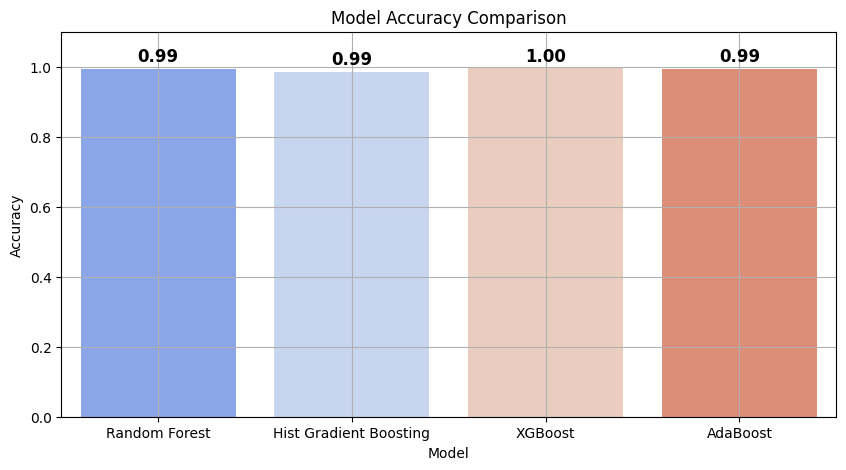

In [ ]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=performance_df["Model"], y=performance_df["Accuracy"], palette="coolwarm")

# Add accuracy values on top of each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 0.02, f"{p.get_height():.2f}",
            ha="center", fontsize=12, fontweight="bold")

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1.1)  # Adjust y-limit to fit the text
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


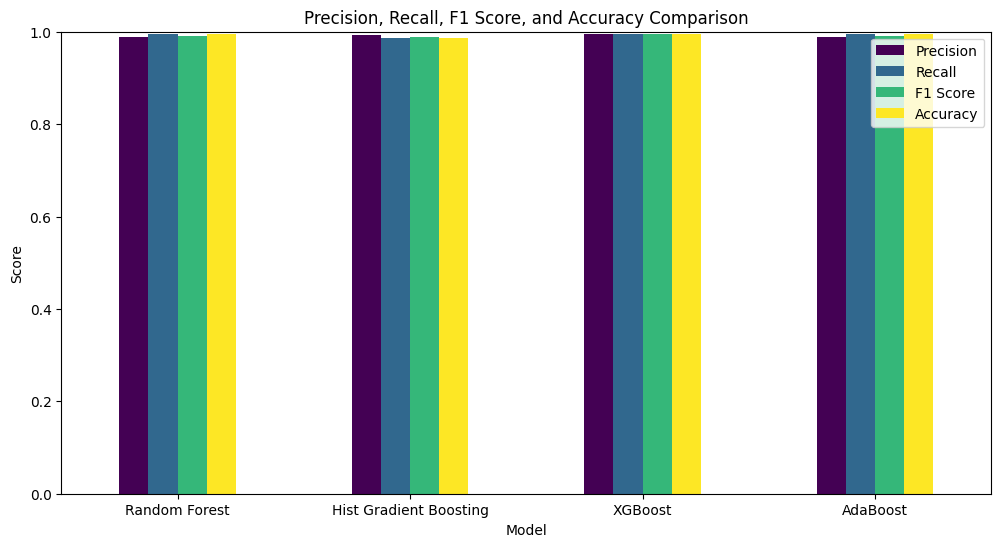

In [ ]:
performance_df.set_index("Model").plot(kind="bar", figsize=(12, 6), colormap="viridis")
plt.title("Precision, Recall, F1 Score, and Accuracy Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.show()


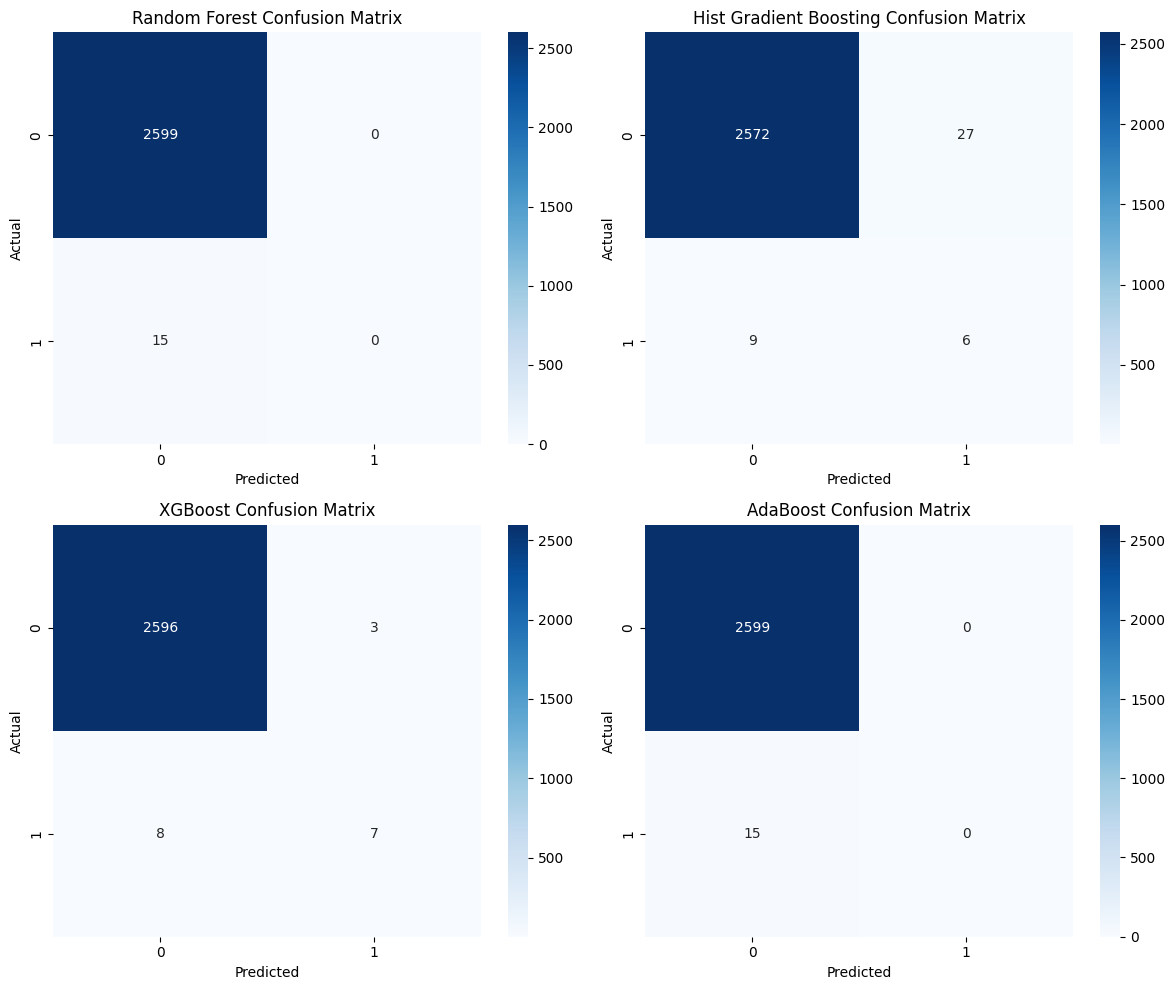

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust for 4 models
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_selected)
    matrix = confusion_matrix(y_test, y_pred)

    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", ax=axes[idx])
    axes[idx].set_title(f"{name} Confusion Matrix")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE #SMOTE (Synthetic Minority Over-sampling Technique)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define ensemble models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42)
}

# Fit and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

# Create a Voting Classifier (soft voting for better probability handling)
voting_clf = VotingClassifier(estimators=[
    ('rf', models['Random Forest']),
    ('gb', models['Gradient Boosting']),
    ('xgb', models['XGBoost']),
    ('ada', models['AdaBoost'])
], voting='soft')

voting_clf.fit(X_train_res, y_train_res)
y_pred_voting = voting_clf.predict(X_test)
results["Voting Classifier"] = accuracy_score(y_test, y_pred_voting)

results


KeyboardInterrupt: 

In [ ]:

# Define models with reduced complexity
optimized_models = {
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, max_depth=5, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=5, random_state=42, eval_metric='logloss', reg_alpha=0.1, reg_lambda=1),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

# Cross-validation results
cv_results = {}
for name, model in optimized_models.items():
    scores = cross_val_score(model, X_train_res, y_train_res, cv=5, scoring='accuracy')
    cv_results[name] = scores.mean()

# Perform RandomizedSearchCV for XGBoost for fine-tuning
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

xgb_random_search = RandomizedSearchCV(estimator=optimized_models['XGBoost'],
                                       param_distributions=param_grid_xgb,
                                       n_iter=10, cv=5, scoring='accuracy', random_state=42)
xgb_random_search.fit(X_train_res, y_train_res)

# Get best XGBoost model and accuracy
best_xgb = xgb_random_search.best_estimator_
best_xgb_accuracy = xgb_random_search.best_score_

cv_results['XGBoost (Tuned)'] = best_xgb_accuracy
cv_results


NameError: name 'cross_val_score' is not defined

In [ ]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Convert sparse matrix to dense format
if hasattr(X_train_res, "toarray"):
    X_train_res = X_train_res.toarray()
    X_test = X_test.toarray()


In [ ]:
# Define New ML Models Only
new_models = {
    "Perceptron": Perceptron(max_iter=1000, tol=1e-3, random_state=42),
    "SGD Classifier": SGDClassifier(max_iter=1000, tol=1e-3, random_state=42),
    "Ridge Classifier": RidgeClassifier(alpha=1.0, random_state=42),
    "Passive Aggressive": PassiveAggressiveClassifier(max_iter=1000, random_state=42),
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
    "Bagging Classifier": BaggingClassifier(n_estimators=100, random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(max_iter=100, random_state=42),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "Gaussian Process": GaussianProcessClassifier(kernel=1.0 * RBF(1.0), random_state=42),
    "Isolation Forest": IsolationForest(n_estimators=100, random_state=42),
    "Dummy Classifier": DummyClassifier(strategy="most_frequent"),
}

# Add KMeans for classification (as a hack for unsupervised clustering)
kmeans = KMeans(n_clusters=len(np.unique(y_train)), random_state=42)
kmeans.fit(X_train_res)
new_models["K-Means"] = kmeans


In [ ]:
print("\nTraining New ML Models...\n")
model_results = {}

for name, model in new_models.items():
    if name == "K-Means":
        # Special case for KMeans (unsupervised)
        y_pred = kmeans.predict(X_test)
    else:
        # Train and predict for other models
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)

    # Calculate accuracy"
    accuracy = accuracy_score(y_test, y_pred)
    model_results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")



Training New ML Models...

Perceptron Accuracy: 0.9935
SGD Classifier Accuracy: 0.9878
Ridge Classifier Accuracy: 0.9782
Passive Aggressive Accuracy: 0.9916
BernoulliNB Accuracy: 0.9319
ComplementNB Accuracy: 0.9629
Linear Discriminant Analysis Accuracy: 0.9748
Quadratic Discriminant Analysis Accuracy: 0.8527
Bagging Classifier Accuracy: 0.9920
HistGradientBoosting Accuracy: 0.9958
MLP Classifier Accuracy: 0.9923


In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
df = pd.read_excel('/content/C__Users_Asus_OneDrive_Desktop_Prj-3_text-only.xlsx')

In [ ]:
df.columns

Index(['id', 'question', 'desired_answer', 'student_answer'], dtype='object')

<ipython-input-12-0ead67b74b71>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Fold', y='Accuracy', palette='Blues_d')


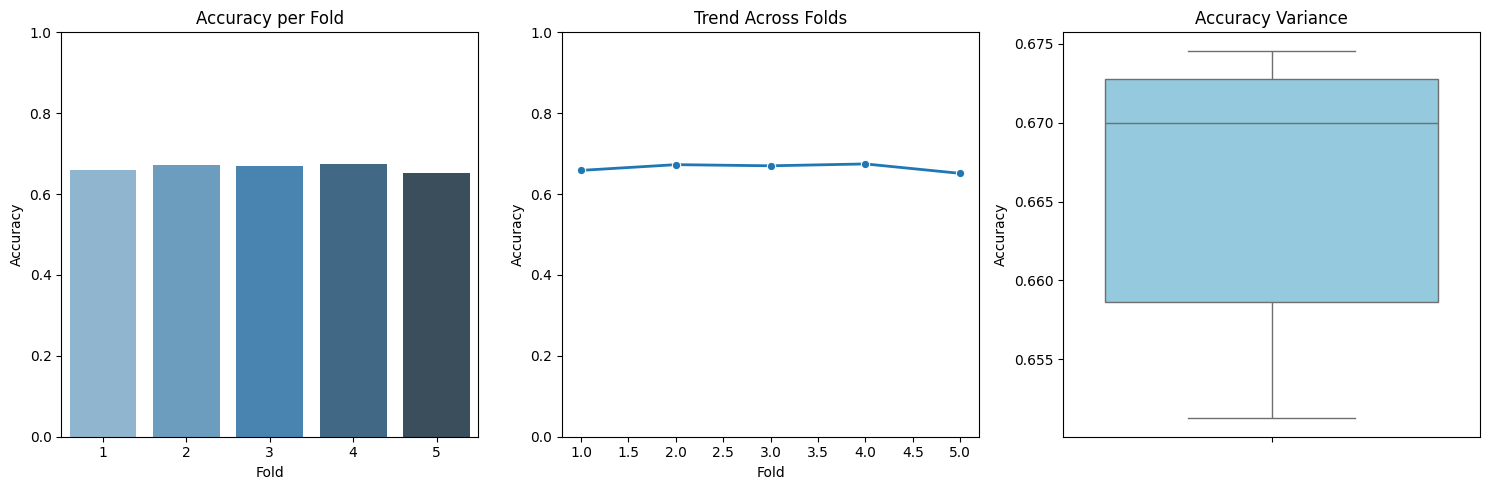

Accuracies across folds: [0.6586391437308868, 0.672782874617737, 0.669980879541109, 0.6745697896749522, 0.6512428298279158]
Mean Accuracy: 0.6654431034785201
Standard Deviation: 0.009007793213633292


In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode student and desired answers
df['student_embed'] = df['student_answer'].apply(lambda x: model.encode(str(x)))
df['desired_embed'] = df['desired_answer'].apply(lambda x: model.encode(str(x)))

# Compute similarity
df['similarity'] = df.apply(lambda row: util.cos_sim(row['student_embed'], row['desired_embed']).item(), axis=1)

# Bin similarity into 3 classes for classification
binning = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
df['label'] = binning.fit_transform(df[['similarity']]).astype(int)

# Feature matrix (student embeddings)
X = np.vstack(df['student_embed'].values)
y = df['label']

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = LogisticRegression(max_iter=1000)
accuracies = []

# Fold counter for plot
fold_num = 1
fold_results = []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)

    fold_results.append({'Fold': fold_num, 'Accuracy': acc})
    fold_num += 1

# Convert results to DataFrame for visualization
results_df = pd.DataFrame(fold_results)

# ----------- 🎨 Visualization -----------
plt.figure(figsize=(15, 5))

# Bar plot
plt.subplot(1, 3, 1)
sns.barplot(data=results_df, x='Fold', y='Accuracy', palette='Blues_d')
plt.title('Accuracy per Fold')
plt.ylim(0, 1)

# Line plot
plt.subplot(1, 3, 2)
sns.lineplot(data=results_df, x='Fold', y='Accuracy', marker='o', linewidth=2)
plt.title('Trend Across Folds')
plt.ylim(0, 1)

# Box plot (distribution)
plt.subplot(1, 3, 3)
sns.boxplot(data=results_df['Accuracy'], color='skyblue')
plt.title('Accuracy Variance')

plt.tight_layout()
plt.show()

# Print summary
print("Accuracies across folds:", accuracies)
print("Mean Accuracy:", np.mean(accuracies))
print("Standard Deviation:", np.std(accuracies))


In [ ]:
import streamlit as st
st.title("Answer Similarity Checker")

question = st.text_area("Enter the Question:")
desired_answer = st.text_area("Desired Answer:")
student_answer = st.text_area("Student Answer:")

if st.button("Check Similarity"):
    # Preprocess and predict
    sim_score = your_model_predict(desired_answer, student_answer)
    st.write(f"Similarity Score: {sim_score:.2f}")
    if sim_score >= 0.75:
        st.success("Answer is likely Correct ✅")
    else:
        st.error("Answer is likely Incorrect ❌")


2025-05-08 17:59:46.445 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 17:59:46.845 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-05-08 17:59:46.856 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 17:59:46.863 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 17:59:46.865 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 17:59:46.867 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 17:59:46.869 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 17:59:46.871 Session state does not 

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.4 MB/s eta 0:00:00
